In [2]:
import os,sys
curr_path = os.getcwd()
sys.path.append('../../codes')
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
import datetime
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # obtain current time

import torch
from itertools import count
import gym
from agent import Agent
from memory import ReplayBuffer,NaivePrioritizedBuffer,NStepReplayBuffer
from common.plot import plot_rewards
from common.utils import save_results,make_dir

# CartPole-v0

In [2]:
class config:
    def __init__(self,agent='DQN',env='CartPole-v0'):
        self.agent = agent             # name of agent
        self.env = env                 # name of environment
        self.result_path = curr_path+"/outputs/" +self.env+'/'+curr_time+'/'+agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env+'/'+curr_time+'/'+agent+'/models/'  # path to save models
        self.train_eps = 700           # number of training episodes
        self.eval_eps = 100            # number of evaluation episodes
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 300  # number of experience stored in memory before learning
        self.learn_freq = 2            # number of steps for one learning 
        self.sync_target_freq = 16     # number of learning steps for sync target model
        self.batch_size = 256          # number of examples in one batch
        self.lr = 0.0001                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.epsilon_start = 0.90      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.01        # ending epsilon
        self.epsilon_decay = 1/5000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'MLP'             # name of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

In [3]:
def init_env_agent(cfg,seed=1):
    ### initial environment ### 
    env = gym.make(cfg.env)  
    env.seed(seed)
    
    ### initial agent ### 
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = Agent(state_dim,action_dim,cfg)
    return env,agent

In [13]:
def try_env(env_id):
    env = gym.make(env_id) #"CartPole-v0"

    actions = ['Left','Right']
#     actions_arrow = ['↑','→','↓','←']

    obs = env.reset()  # 重置一个 episode
    for i in range(1000):
        print('ROUND',i)
        env.render()  # 显示图形界面
        print('\nFROM',obs)
        action = env.action_space.sample() # 从动作空间中随机选取一个动作
#         print(actions[action])
        obs, reward, done , _ = env.step(action) # 用于提交动作，括号内是具体的动作
        print('END',obs)
        print('-'*10)
    env.close() # 关闭环境
# try_env('Pong-v0')

# from IPython import display
# import matplotlib
# import matplotlib.pyplot as plt
# %matplotlib inline

# # env = gym.make('MountainCar-v0')
# env = gym.make('CartPole-v0')
# env.reset()
# img = plt.imshow(env.render(mode='rgb_array')) # only call this once
# for _ in range(100):
#     img.set_data(env.render(mode='rgb_array')) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     action = env.action_space.sample()
#     env.step(action)

In [6]:
def train(cfg,env,agent):
    rewards, ma_rewards = [], []
    for i_eps in range(cfg.train_eps):
        state = env.reset()
        eps_reward = 0
        done = False
        
        ### run until done ###
        for i in count():
            action = agent.sample(state)
            next_state,reward,done,_ = env.step(action)
            eps_reward += reward
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            if len(agent.memory) > cfg.memory_warmup_size and i%cfg.learn_freq==0:
                 agent.learn()
            if done:
                break

        ### recording for each episode ###
        rewards.append(eps_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+eps_reward*0.1)
        else:
            ma_rewards.append(eps_reward)
        if (i_eps+1)%10==0:
            print(f"Episode:{i_eps+1}/{cfg.train_eps}: reward:{eps_reward:.1f}")       
    return ma_rewards, rewards

In [7]:
def evaluate(cfg,env,agent,render=False):
    rewards, ma_rewards = [], []
    for i_eps in range(cfg.eval_eps):
        state = env.reset()
        eps_reward = 0
        done = False
        while not done:
            if render:
                env.render()  
            action = agent.predict(state)
            next_state,reward,done,_ = env.step(action)
            eps_reward += reward
            state = next_state

        rewards.append(eps_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+eps_reward*0.1)
        else:
            ma_rewards.append(eps_reward)
        if (i_eps+1)%10==0:
            print(f"Episode:{i_eps+1}/{cfg.train_eps}: reward:{eps_reward:.1f}")       
    return ma_rewards, rewards

In [7]:
def main():
    agent = 'DQN'
    print(agent)
    cfg = config(agent)
    
    env,agent = init_env_agent(cfg,seed=1)
    ma_rewards,rewards = train(cfg,env,agent)
    make_dir(cfg.result_path,cfg.model_path)
    agent.save(path=cfg.model_path)
    save_results(rewards,ma_rewards,tag='train',path=cfg.result_path)
    plot_rewards(rewards,ma_rewards,tag="train",env=cfg.env,algo = cfg.agent,path=cfg.result_path)

    env,agent = init_env_agent(cfg,seed=10)
    agent.load(path=cfg.model_path)
    ma_rewards,rewards = evaluate(cfg,env,agent,render=False)
    save_results(rewards,ma_rewards,tag='eval',path=cfg.result_path)
    plot_rewards(rewards,ma_rewards,tag="eval",env=cfg.env,algo = cfg.agent,path=cfg.result_path)

DQN
Episode:10/700: reward:17.0
Episode:20/700: reward:16.0
Episode:30/700: reward:25.0
Episode:40/700: reward:20.0
Episode:50/700: reward:9.0
Episode:60/700: reward:36.0
Episode:70/700: reward:19.0
Episode:80/700: reward:10.0
Episode:90/700: reward:46.0
Episode:100/700: reward:25.0
Episode:110/700: reward:117.0
Episode:120/700: reward:200.0
Episode:130/700: reward:200.0
Episode:140/700: reward:200.0
Episode:150/700: reward:200.0
Episode:160/700: reward:200.0
Episode:170/700: reward:200.0
Episode:180/700: reward:200.0
Episode:190/700: reward:200.0
Episode:200/700: reward:200.0
Episode:210/700: reward:200.0
Episode:220/700: reward:200.0
Episode:230/700: reward:200.0
Episode:240/700: reward:200.0
Episode:250/700: reward:200.0
Episode:260/700: reward:200.0
Episode:270/700: reward:200.0
Episode:280/700: reward:200.0
Episode:290/700: reward:200.0
Episode:300/700: reward:200.0
Episode:310/700: reward:200.0
Episode:320/700: reward:200.0
Episode:330/700: reward:200.0
Episode:340/700: reward:20

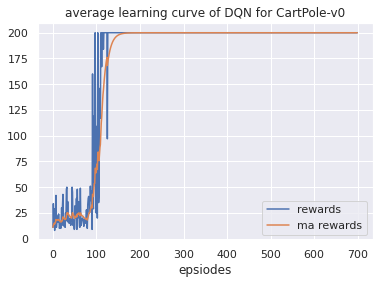

Episode:10/700: reward:200.0
Episode:20/700: reward:200.0
Episode:30/700: reward:200.0
Episode:40/700: reward:200.0
Episode:50/700: reward:200.0
Episode:60/700: reward:200.0
Episode:70/700: reward:200.0
Episode:80/700: reward:200.0
Episode:90/700: reward:200.0
Episode:100/700: reward:200.0
results saved!


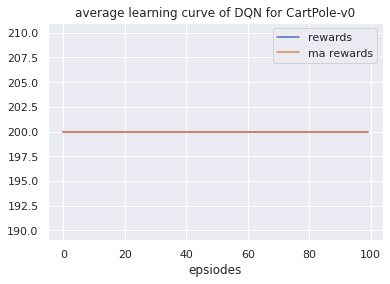

In [37]:
main()

# Pong

In [2]:
### check your registered env ###
# from gym import envs
# env_names = [spec.id for spec in envs.registry.all()] 
# for name in sorted(env_names): 
#     print(name)

### download atari games ###
# 1. download ROMS from http://www.atarimania.com/rom_collection_archive_atari_2600_roms.html
# 2. extract files in Roms.rar

## METHOD 1##
# python -m atari_py.import_roms path_of_your_ROMS
# import gym
# gym.make("Pong-v0")

## METHOD 2 ##
# pip install gym-retro
# python -m retro.import path_of_your_ROMS
# import retro
# retro.make(game="SpaceInvaders-Atari2600")



In [2]:
from common.atari_wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [3]:
### knowing what actions represent ###
# from IPython import display
# from PIL import Image

# # action 0 and 1 seems useless, as nothing happens to the racket.
# # action 2 & 4 makes the racket go up, and action 3 & 5 makes the racket go down.
# env = gym.make('PongNoFrameskip-v4')
# print(env.unwrapped.get_action_meanings())
# action = 4  # modify this!
# o = env.reset()
# for i in range(10): # repeat one action for five times
#     o = env.step(action)[0]
#     display.display(Image.fromarray(o))

In [4]:
def try_cutting(env_id):
    env = gym.make(env_id)
    state = env.reset()

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(state) #(210, 160, 3)
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(state[34:194]) #(160,160,3)
# try_cutting("PongNoFrameskip-v4")

In [9]:
def init_env_agent(cfg,seed=1):
    ### initial environment ### 
    env = make_atari(cfg.env_id)
    env = wrap_deepmind(env)
    env = wrap_pytorch(env) 
    env.seed(seed)
    
    ### initial agent ### 
    if len(env.observation_space.shape) == 1:
        state_dim = env.observation_space.shape[0]
    else:
        state_dim = env.observation_space.shape
    action_dim = env.action_space.n
    agent = Agent(state_dim,action_dim,cfg)
    return env,agent

In [10]:
class config:
    def __init__(self,agent='DQN',env_id='CartPole-v0'):
        self.agent = agent             # name of agent
        self.env_id = env_id           # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+agent+'/models/'  # path to save models
        self.train_eps = 700           # number of training episodes
        self.eval_eps = 50            # number of evaluation episodes
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 300  # number of experience stored in memory before learning
        self.learn_freq = 2            # number of steps for one learning 
        self.sync_target_freq = 16     # number of learning steps for sync target model
        self.batch_size = 128          # number of examples in one batch
        self.lr = 0.000001                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.epsilon_start = 0.98      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.01        # ending epsilon
        self.epsilon_decay = 1/50000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'CNN'             # name of model
        self.hidden_dim = 512           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

In [17]:
def train(cfg,env,agent):
    i_frame,frames = 0,[]
    rewards, ma_rewards,losses = [], [], []
    for i_eps in range(cfg.train_eps):
        state = env.reset()
        eps_reward = 0
        done = False
        
        ### run until done ###
        for i in count():
            i_frame += 1
            action = agent.sample(state)
            next_state,reward,done,_ = env.step(action)
            eps_reward += reward
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            if len(agent.memory) > cfg.memory_warmup_size and i%cfg.learn_freq==0:
                batch_state,batch_action,batch_reward,batch_next_state,batch_done = agent.memory.sample(agent.batch_size)
                loss = agent.learn(batch_state,batch_action,batch_reward,batch_next_state,batch_done)
                losses.append(loss)
            if done:
                break

        ### recording for each episode ###
        rewards.append(eps_reward)
        frames.append(i_frame)
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+eps_reward*0.1)
        else:
            ma_rewards.append(eps_reward)
        if (i_eps+1)%10==0:
            print(f"[{time}: {cfg.agent}] Frame:{i_frame}: Episode:{i_eps+1}/{cfg.train_eps}: reward:{eps_reward:.1f}: loss:{loss:.4f}")
        if (i_eps+1)%100==0:
            make_dir(cfg.result_path,cfg.model_path+time)
            agent.save(path=cfg.model_path+time+'/')
    return frames, rewards, ma_rewards, losses

In [12]:
def evaluate(cfg,env,agent,render=False):
    rewards, ma_rewards = [], []
    for i_eps in range(cfg.eval_eps):
        state = env.reset()
        eps_reward = 0
        done = False
        while not done:
            if render:
                env.render()  
            action = agent.predict(state)
            next_state,reward,done,_ = env.step(action)
            eps_reward += reward
            state = next_state

        rewards.append(eps_reward)
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+eps_reward*0.1)
        else:
            ma_rewards.append(eps_reward)
        if (i_eps+1)%10==0:
            print(f"[{time}: {cfg.agent}] Episode:{i_eps+1}/{cfg.train_eps}: reward:{eps_reward:.1f}")   
    return rewards, ma_rewards

In [9]:
def main():
    agent = 'DQN'
    env_id = "PongNoFrameskip-v4"
    print(agent,env_id)
    cfg = config(agent,env_id)
    
    his = {}
    env,agent = init_env_agent(cfg,seed=1)
    frames, rewards, ma_rewards,losses = train(cfg,env,agent)
    his['frames'],his['rewards'],his['ma_rewards'],his['losses'] = frames, rewards, ma_rewards
    make_dir(cfg.result_path,cfg.model_path)
    agent.save(path=cfg.model_path)
    save_results(his,tag='train',path=cfg.result_path)
    plot_rewards(rewards,ma_rewards,tag="train",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

    his = {}
    env,agent = init_env_agent(cfg,seed=10)
    agent.load(path=cfg.model_path)
    rewards, ma_rewards = evaluate(cfg,env,agent,render=True)
    his['rewards'],his['ma_rewards'] = rewards, ma_rewards
    save_results(his,tag='eval',path=cfg.result_path)
    plot_rewards(rewards,ma_rewards,tag="eval",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

In [48]:
batch_state,batch_action,batch_reward,batch_next_state,batch_done = agent.memory.sample(2)
batch_state = torch.as_tensor(batch_state, device=cfg.device, dtype=torch.float32)  #[2, 1, 84, 84]
batch_action = torch.as_tensor(batch_action,device=cfg.device).unsqueeze(1) #[2, 1]
batch_reward = torch.as_tensor(batch_reward,device=cfg.device, dtype=torch.float32) #[2]
batch_next_state = torch.as_tensor(batch_next_state, device=cfg.device, dtype=torch.float32) #[2, 1, 84, 84]
batch_done = torch.as_tensor(np.float32(batch_done), device=cfg.device) #[2]
batch_done

tensor([0., 0.], device='cuda:0')

DQN PongNoFrameskip-v4
[20210609-153137: DQN] Frame:9093: Episode:10/700: reward:-19.0
[20210609-154237: DQN] Frame:18375: Episode:20/700: reward:-21.0
[20210609-155254: DQN] Frame:27247: Episode:30/700: reward:-20.0
[20210609-160333: DQN] Frame:36418: Episode:40/700: reward:-20.0
[20210609-161536: DQN] Frame:46746: Episode:50/700: reward:-18.0
[20210609-163033: DQN] Frame:59402: Episode:60/700: reward:-18.0
[20210609-164619: DQN] Frame:72650: Episode:70/700: reward:-17.0
[20210609-170637: DQN] Frame:89006: Episode:80/700: reward:-19.0
[20210609-172839: DQN] Frame:106318: Episode:90/700: reward:-16.0
[20210609-175028: DQN] Frame:124121: Episode:100/700: reward:-16.0
[20210609-181322: DQN] Frame:143437: Episode:110/700: reward:-15.0
[20210609-183802: DQN] Frame:164059: Episode:120/700: reward:-18.0
[20210609-190318: DQN] Frame:185264: Episode:130/700: reward:-15.0
[20210609-192823: DQN] Frame:206380: Episode:140/700: reward:-13.0
[20210609-195754: DQN] Frame:230862: Episode:150/700: rew

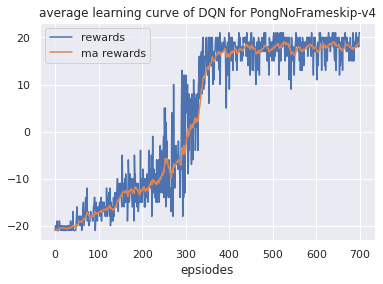

[20210610-220714: DQN] Episode:10/700: reward:20.0
[20210610-221242: DQN] Episode:20/700: reward:20.0
[20210610-221815: DQN] Episode:30/700: reward:20.0
[20210610-222343: DQN] Episode:40/700: reward:20.0
[20210610-222911: DQN] Episode:50/700: reward:20.0
results saved!


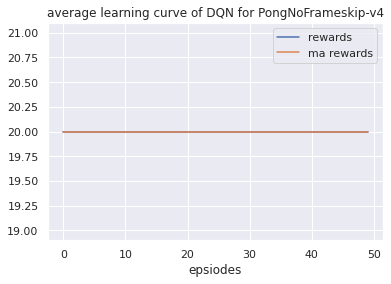

In [11]:
main()

# multi-envs + 1 agent

In [2]:
from common.atari_wrappers import make_atari, wrap_deepmind, wrap_pytorch
import tianshou as ts
from replay_buffer import PrioritizedReplayBuffer

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
def make_env(env_id,seed=1):
    env = make_atari(env_id)
    env = wrap_deepmind(env,episode_life=True)
    env = wrap_pytorch(env) 
#     env = gym.make(env_id)
    if seed: env.seed(seed)
    return env
def init_envs_agent(cfg,nenv,seed=1):
    envs = ts.env.ShmemVectorEnv([lambda: make_env(cfg.env_id,seed) for _ in range(nenv)])
#     envs = ts.env.SubprocVectorEnv([lambda: make_env(cfg.env_id,seed) for _ in range(cfg.nenv)])
    if len(envs.observation_space[0].shape) == 1:
        state_dim = envs.observation_space[0].shape[0]
    else:
        state_dim = envs.observation_space[0].shape
    action_dim = envs.action_space[0].n
    agent = Agent(state_dim,action_dim,cfg)
    return envs,agent
    
#<ImageToPyTorch<ClipRewardEnv<WarpFrame<FireResetEnv<EpisodicLifeEnv<MaxAndSkipEnv<NoopResetEnv<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>>>>>>>

In [5]:
### slower than ts.env.SubprocVectorEnv ###
# from common.multiprocessing_env import SubprocVecEnv
# def make_env(env_name,seed=1):
#     env = make_atari(env_name)
#     env = wrap_deepmind(env,episode_life=False)
#     env = wrap_pytorch(env) 
#     return env
# def init_envs_agent(cfg,nenv,seed=1):
#     envs = SubprocVecEnv([lambda:make_env(cfg.env_id) for i in range(nenv)])
#     state_dim = envs.observation_space.shape
#     action_dim = envs.action_space.n
#     agent = Agent(state_dim,action_dim,cfg)
#     return envs,agent

In [6]:
def train(cfg,envs,agent):
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    envs.seed(cfg.seed)
    
    print('Start Training!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames'],history['loss']  = [],[],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_train_env),np.zeros(cfg.n_train_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0
    memorys = [NStepReplayBuffer(cfg.n_multi_step,cfg.gamma, ReplayBuffer(cfg.memory_size)) 
                for _ in range(cfg.n_train_env)]

    states = envs.reset()
    while i_frame < cfg.max_train_frames: #1500000: #
        ### interactive with environments ###
        actions = agent.sample(states)
        if cfg.n_train_env == 1: actions = [actions]
    #     actions = np.random.randint(6,size=cfg.n_train_env)
        next_states,rewards,dones,infos = envs.step(actions)
        eps_rewards += rewards
        done_envs_ids = np.where(dones)[0]
        eps_frames += 1
        for memory,s,a,r,next_s,done in zip(memorys, states, actions, rewards, next_states, dones):
            memory.push(s,a,r,next_s,done)
        states = next_states
        i_frame += len(actions)
        ### updating agent ###
        if all([len(memory)>cfg.memory_warmup_size for memory in memorys]) and i_frame%cfg.learn_freq==0:
            batch_state,batch_action,batch_reward,batch_next_state,batch_done = [],[],[],[],[]
            sample_ids = np.random.choice(cfg.n_train_env,cfg.batch_size,p=[1/cfg.n_train_env]*cfg.n_train_env)
            sample_num = np.bincount(sample_ids, minlength=cfg.n_train_env)
            sample_num[sample_num==0] = 4
            for i,n in enumerate(sample_num):
                s,a,r,ns,d = memorys[i].sample(n)
                batch_state.append(s)
                batch_action.append(a)
                batch_reward.append(r)
                batch_next_state.append(ns)
                batch_done.append(d)
            batch_state,batch_action,batch_reward,batch_next_state,batch_done = map(
                lambda x:np.concatenate(x),[batch_state,batch_action,batch_reward,batch_next_state,batch_done])
            loss = agent.learn(batch_state,batch_action,batch_reward,batch_next_state,batch_done)
            history['loss'].append(loss)
        ### recording historys ###
        if len(done_envs_ids) > 0:
            for r in eps_rewards[done_envs_ids]:
                history['rewards'].append(r)
                if history['ma_rewards']:
                    history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                else:
                    history['ma_rewards'].append(r)
            for n in eps_frames[done_envs_ids]:
                if history['frames']:
                    history['frames'].append(history['frames'][-1] + n)
                else:
                    history['frames'].append(n)
            eps_frames[done_envs_ids] = 0
            eps_rewards[done_envs_ids] = 0
            states[done_envs_ids] = envs.reset(done_envs_ids)
    #         print(history,done_envs_ids,eps_rewards)aa
    #         break
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 1000:
                prev_frame_verbose = history['frames'][-1]
                if history['loss']:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}: Loss:{history['loss'][-1]:.4f}")
                else:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
            if history['frames'][-1] - prev_frame_save >= cfg.max_train_frames//10:
                prev_frame_save = history['frames'][-1]
                make_dir(cfg.result_path,cfg.model_path+time)
                agent.save(path=cfg.model_path+time+'/')
    make_dir(cfg.result_path,cfg.model_path+time)
    agent.save(path=cfg.model_path+time+'/')
    return history

In [7]:
def evaluate(cfg,envs,agent,render=False):
    envs.seed(1)
    print('Start Evaluating!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames']  = [],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_eval_env),np.zeros(cfg.n_eval_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0

    states = envs.reset()
    while i_frame < cfg.max_eval_frames:
        ### interactive with environments ###
        if render: envs.render()
        actions = agent.predict(states).cpu().numpy()
        if cfg.n_eval_env == 1: actions = [actions]
        next_states,rewards,dones,infos = envs.step(actions)
        eps_rewards += rewards
        done_envs_ids = np.where(dones)[0]
        eps_frames += 1
        states = next_states
        i_frame += len(actions)

        ### recording historys ###
        if len(done_envs_ids) > 0:
            for r in eps_rewards[done_envs_ids]:
                history['rewards'].append(r)
                if history['ma_rewards']:
                    history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                else:
                    history['ma_rewards'].append(r)
            for n in eps_frames[done_envs_ids]:
                if history['frames']:
                    history['frames'].append(history['frames'][-1] + n)
                else:
                    history['frames'].append(n)
            eps_frames[done_envs_ids] = 0
            eps_rewards[done_envs_ids] = 0
            states[done_envs_ids] = envs.reset(done_envs_ids)
            
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 10:
                prev_frame_verbose = history['frames'][-1]
                print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
    return history

In [8]:
def main():
    cfg = config()
    print(cfg.agent,cfg.env_id)
    
    envs,agent = init_envs_agent(cfg,cfg.n_train_env)
    history = train(cfg,envs,agent)
    make_dir(cfg.result_path,cfg.model_path)
    agent.save(path=cfg.model_path)
    save_results(history,tag='train',path=cfg.result_path)
    plot_rewards(history['rewards'],history['ma_rewards'],tag="train",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

    eval_envs,agent = init_envs_agent(cfg,cfg.n_eval_env,seed=10)
    agent.load(path=cfg.model_path)
    history = evaluate(cfg,eval_envs,agent,render=False)
    save_results(history,tag='eval',path=cfg.result_path)
    plot_rewards(history['rewards'],history['ma_rewards'],tag="eval",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

# Rainbow_DQN

In [23]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'rainbow_DQN'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 1.2e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 300*2  # number of experience stored in memory before learning
        self.PER_alpha = 0.6                      # alpha for Prioritized Experience Replay, 0 - no importance sampling (IS); 1 - most IS 
        self.PER_beta = 0.4                       # beta for Prioritized Experience Replay, 0 - no annealing the bias from IS; 1 - Annealing the bias from IS 
        self.PER_beta_decay_method = None #'Linear'     # if None: no decay for PER beta
        self.PER_beta_decay = 1/self.memory_size/2  # decay rate for PER beta
        self.learn_freq = 2            # number of steps for one learning 
        self.sync_target_freq = 32     # number of learning steps for sync target model
        self.batch_size = 128*4          # number of examples in one batch
        self.lr = 0.0002                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.n_multi_step = 2          # number of steps of multi-step style gain 
        self.epsilon_start = 0.90      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.001        # ending epsilon
        self.epsilon_decay = 1/2500    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'RainbowCNN'             # name of model
        self.Vmin = -10                 # lower bound of the uniform distribution of the categories
        self.Vmax = 10                  # upper bound of the uniform distribution of the categories
        self.num_atoms = 51             # number of classes in the uniform distribution of the categories
        self.hidden_dim = 512           # dimmension of hidden layer
        self.noisy_std = 0.5            # standard devision for noisy net 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

In [19]:
def train(cfg,envs,agent):
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    envs.seed(cfg.seed)

    print('Start Training!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames'],history['loss']  = [],[],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_train_env),np.zeros(cfg.n_train_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0
    # memorys = [NStepReplayBuffer(cfg.n_multi_step,cfg.gamma, 
    #                              PrioritizedReplayBuffer(cfg.memory_size//cfg.n_train_env,cfg.PER_alpha)) 
    #             for _ in range(cfg.n_train_env)]
    memorys = [NStepReplayBuffer(cfg.n_multi_step,cfg.gamma, 
                                 NaivePrioritizedBuffer(cfg.memory_size//cfg.n_train_env,cfg.PER_alpha)) 
                for _ in range(cfg.n_train_env)]
    if cfg.PER_beta_decay_method == 'Linear':
        PER_beta = lambda frame_idx: min(1.0, cfg.PER_beta + frame_idx * (1.0 - cfg.PER_beta)*cfg.PER_beta_decay)
    else:
        PER_beta = lambda frame_idx: min(1.0, cfg.PER_beta)

    states = envs.reset()
    while i_frame < cfg.max_train_frames:
        ### interactive with environments ###
        actions = agent.sample(states)
        if cfg.n_train_env == 1: actions = [actions]
    #     actions = np.random.randint(6,size=cfg.n_train_env)
        next_states,rewards,dones,infos = envs.step(actions)
        eps_rewards += rewards
        done_envs_ids = np.where(dones)[0]
        eps_frames += 1
        for memory,s,a,r,next_s,done in zip(memorys, states, actions, rewards, next_states, dones):
            memory.push(s,a,r,next_s,done)
        states = next_states
        i_frame += len(actions)
        ### updating agent ###
        if all([len(memory)>cfg.memory_warmup_size for memory in memorys]) and i_frame%cfg.learn_freq==0:
            batch_state,batch_action,batch_reward,batch_next_state,batch_done,batch_weight,batch_idx = [],[],[],[],[],[],[]
            sample_ids = np.random.choice(cfg.n_train_env,cfg.batch_size,p=[1/cfg.n_train_env]*cfg.n_train_env)
            sample_num = np.bincount(sample_ids, minlength=cfg.n_train_env)
            sample_num[sample_num==0] = 4
            for i,n in enumerate(sample_num):
                s,a,r,ns,d,w,idx = memorys[i].sample(n,PER_beta(agent.sample_steps))
                for batch, x in zip([batch_state,batch_action,batch_reward,batch_next_state,batch_done,batch_weight,batch_idx],
                                    [s,a,r,ns,d,w,idx]):
                    batch.append(x)
            batch_state,batch_action,batch_reward,batch_next_state,batch_done,batch_weight,batch_idx = map(
                lambda x:np.concatenate(x),[batch_state,batch_action,batch_reward,batch_next_state,batch_done,batch_weight,batch_idx])
            prios = agent.learn(batch_state,batch_action,batch_reward,batch_next_state,batch_done,batch_weight)
            prev_n = 0 
            for i,n in enumerate(sample_num):
                memorys[i].update_priorities(batch_idx[prev_n:prev_n+n],prios[prev_n:prev_n+n])
                prev_n += n
            history['loss'].append(prios.mean())
        ### recording historys ###
        if len(done_envs_ids) > 0:
            for r in eps_rewards[done_envs_ids]:
                history['rewards'].append(r)
                if history['ma_rewards']:
                    history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                else:
                    history['ma_rewards'].append(r)
            for n in eps_frames[done_envs_ids]:
                if history['frames']:
                    history['frames'].append(history['frames'][-1] + n)
                else:
                    history['frames'].append(n)
            eps_frames[done_envs_ids] = 0
            eps_rewards[done_envs_ids] = 0
            states[done_envs_ids] = envs.reset(done_envs_ids)
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 1000:
                prev_frame_verbose = history['frames'][-1]
                if history['loss']:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}: Loss:{history['loss'][-1]:.4f}")
                else:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
            if history['frames'][-1] - prev_frame_save >= cfg.max_train_frames//10:
                prev_frame_save = history['frames'][-1]
                make_dir(cfg.result_path,cfg.model_path+time)
                agent.save(path=cfg.model_path+time+'/')
    make_dir(cfg.result_path,cfg.model_path+time)
    agent.save(path=cfg.model_path+time+'/')
    return history

rainbow_DQN PongNoFrameskip-v4
Start Training!
20210707-092638
[20210707-092650: rainbow_DQN] Episode:1: Frame:773.0: Reward:-21.0: Loss:13.5981
[20210707-092652: rainbow_DQN] Episode:4: Frame:3191.0: Reward:-21.0: Loss:14.4930
[20210707-092653: rainbow_DQN] Episode:6: Frame:4847.0: Reward:-21.0: Loss:14.1023
[20210707-092653: rainbow_DQN] Episode:8: Frame:6538.0: Reward:-21.0: Loss:13.3613
[20210707-092656: rainbow_DQN] Episode:10: Frame:8298.0: Reward:-20.0: Loss:13.9987
[20210707-092658: rainbow_DQN] Episode:12: Frame:10182.0: Reward:-20.0: Loss:13.2967
[20210707-092659: rainbow_DQN] Episode:14: Frame:12130.0: Reward:-20.0: Loss:13.5140
[20210707-092701: rainbow_DQN] Episode:15: Frame:13147.0: Reward:-21.0: Loss:14.0486
[20210707-092702: rainbow_DQN] Episode:16: Frame:14192.0: Reward:-19.0: Loss:14.8543
[20210707-092724: rainbow_DQN] Episode:18: Frame:15770.0: Reward:-21.0: Loss:14.0429
[20210707-092725: rainbow_DQN] Episode:20: Frame:17348.0: Reward:-21.0: Loss:13.7864
[20210707-09

[20210707-093456: rainbow_DQN] Episode:146: Frame:154453.0: Reward:-15.0: Loss:11.4624
[20210707-093513: rainbow_DQN] Episode:147: Frame:156043.0: Reward:-17.0: Loss:11.8107
[20210707-093519: rainbow_DQN] Episode:148: Frame:157696.0: Reward:-17.0: Loss:11.8813
[20210707-093520: rainbow_DQN] Episode:149: Frame:158912.0: Reward:-18.0: Loss:11.5760
[20210707-093520: rainbow_DQN] Episode:150: Frame:160596.0: Reward:-15.0: Loss:11.6580
[20210707-093534: rainbow_DQN] Episode:151: Frame:162034.0: Reward:-17.0: Loss:11.5981
[20210707-093540: rainbow_DQN] Episode:152: Frame:164091.0: Reward:-16.0: Loss:11.5230
[20210707-093543: rainbow_DQN] Episode:153: Frame:165757.0: Reward:-17.0: Loss:11.5239
[20210707-093558: rainbow_DQN] Episode:154: Frame:167716.0: Reward:-13.0: Loss:11.3491
[20210707-093601: rainbow_DQN] Episode:155: Frame:169486.0: Reward:-17.0: Loss:11.2620
[20210707-093604: rainbow_DQN] Episode:156: Frame:170993.0: Reward:-18.0: Loss:11.5432
[20210707-093607: rainbow_DQN] Episode:157:

[20210707-094816: rainbow_DQN] Episode:241: Frame:383445.0: Reward:4.0: Loss:11.5526
[20210707-094826: rainbow_DQN] Episode:242: Frame:386609.0: Reward:4.0: Loss:11.6603
[20210707-094903: rainbow_DQN] Episode:243: Frame:389152.0: Reward:10.0: Loss:11.4231
[20210707-094909: rainbow_DQN] Episode:244: Frame:392186.0: Reward:4.0: Loss:11.5567
[20210707-094910: rainbow_DQN] Episode:245: Frame:394916.0: Reward:10.0: Loss:11.4428
[20210707-094913: rainbow_DQN] Episode:246: Frame:397404.0: Reward:11.0: Loss:11.3185
[20210707-094925: rainbow_DQN] Episode:247: Frame:399451.0: Reward:18.0: Loss:11.5952
[20210707-094942: rainbow_DQN] Episode:248: Frame:401717.0: Reward:13.0: Loss:11.5962
[20210707-094953: rainbow_DQN] Episode:249: Frame:404400.0: Reward:7.0: Loss:11.5013
[20210707-095014: rainbow_DQN] Episode:250: Frame:407581.0: Reward:4.0: Loss:11.4954
[20210707-095018: rainbow_DQN] Episode:251: Frame:410194.0: Reward:9.0: Loss:11.4566
[20210707-095019: rainbow_DQN] Episode:252: Frame:413201.0: 

[20210707-100137: rainbow_DQN] Episode:337: Frame:593243.0: Reward:17.0: Loss:11.3907
[20210707-100138: rainbow_DQN] Episode:338: Frame:595130.0: Reward:19.0: Loss:11.2147
[20210707-100140: rainbow_DQN] Episode:339: Frame:597022.0: Reward:19.0: Loss:11.2708
[20210707-100145: rainbow_DQN] Episode:340: Frame:598715.0: Reward:20.0: Loss:11.1329
[20210707-100147: rainbow_DQN] Episode:341: Frame:600624.0: Reward:19.0: Loss:11.2603
[20210707-100150: rainbow_DQN] Episode:342: Frame:602717.0: Reward:18.0: Loss:11.1129
[20210707-100152: rainbow_DQN] Episode:343: Frame:604507.0: Reward:19.0: Loss:11.4073
[20210707-100219: rainbow_DQN] Episode:344: Frame:606233.0: Reward:20.0: Loss:11.0657
[20210707-100248: rainbow_DQN] Episode:345: Frame:608609.0: Reward:13.0: Loss:11.0137
[20210707-100301: rainbow_DQN] Episode:346: Frame:610525.0: Reward:16.0: Loss:11.1367
[20210707-100308: rainbow_DQN] Episode:347: Frame:612606.0: Reward:17.0: Loss:10.8676
[20210707-100314: rainbow_DQN] Episode:348: Frame:6146

[20210707-101307: rainbow_DQN] Episode:435: Frame:784104.0: Reward:13.0: Loss:11.2424
[20210707-101308: rainbow_DQN] Episode:436: Frame:786027.0: Reward:18.0: Loss:11.1948
[20210707-101325: rainbow_DQN] Episode:437: Frame:788385.0: Reward:14.0: Loss:11.3124
[20210707-101335: rainbow_DQN] Episode:438: Frame:790438.0: Reward:16.0: Loss:11.3789
[20210707-101338: rainbow_DQN] Episode:439: Frame:792424.0: Reward:15.0: Loss:11.2172
[20210707-101351: rainbow_DQN] Episode:440: Frame:794052.0: Reward:21.0: Loss:11.4103
[20210707-101402: rainbow_DQN] Episode:441: Frame:795809.0: Reward:19.0: Loss:11.4159
[20210707-101406: rainbow_DQN] Episode:442: Frame:797604.0: Reward:18.0: Loss:11.2828
[20210707-101410: rainbow_DQN] Episode:443: Frame:799234.0: Reward:21.0: Loss:11.2103
[20210707-101416: rainbow_DQN] Episode:444: Frame:800940.0: Reward:20.0: Loss:11.1926
[20210707-101419: rainbow_DQN] Episode:445: Frame:802808.0: Reward:16.0: Loss:11.3176
[20210707-101427: rainbow_DQN] Episode:446: Frame:8047

[20210707-102413: rainbow_DQN] Episode:533: Frame:964395.0: Reward:20.0: Loss:11.1186
[20210707-102421: rainbow_DQN] Episode:534: Frame:966019.0: Reward:21.0: Loss:11.1425
[20210707-102436: rainbow_DQN] Episode:535: Frame:967704.0: Reward:20.0: Loss:11.1011
[20210707-102437: rainbow_DQN] Episode:536: Frame:969323.0: Reward:20.0: Loss:10.9726
[20210707-102437: rainbow_DQN] Episode:537: Frame:970968.0: Reward:21.0: Loss:10.9660
[20210707-102442: rainbow_DQN] Episode:538: Frame:972591.0: Reward:21.0: Loss:11.0960
[20210707-102443: rainbow_DQN] Episode:539: Frame:974218.0: Reward:21.0: Loss:11.0233
[20210707-102446: rainbow_DQN] Episode:540: Frame:975893.0: Reward:20.0: Loss:10.9348
[20210707-102447: rainbow_DQN] Episode:541: Frame:977605.0: Reward:20.0: Loss:11.1116
[20210707-102457: rainbow_DQN] Episode:542: Frame:979511.0: Reward:17.0: Loss:11.0705
[20210707-102503: rainbow_DQN] Episode:543: Frame:981122.0: Reward:20.0: Loss:10.9835
[20210707-102513: rainbow_DQN] Episode:544: Frame:9828

[20210707-103352: rainbow_DQN] Episode:628: Frame:1127962.0: Reward:21.0: Loss:11.2113
[20210707-103404: rainbow_DQN] Episode:629: Frame:1129568.0: Reward:21.0: Loss:11.2939
[20210707-103410: rainbow_DQN] Episode:630: Frame:1131280.0: Reward:19.0: Loss:11.3011
[20210707-103410: rainbow_DQN] Episode:631: Frame:1132915.0: Reward:21.0: Loss:11.1196
[20210707-103411: rainbow_DQN] Episode:632: Frame:1134730.0: Reward:20.0: Loss:11.2952
[20210707-103430: rainbow_DQN] Episode:633: Frame:1136373.0: Reward:20.0: Loss:11.3686
[20210707-103449: rainbow_DQN] Episode:634: Frame:1138085.0: Reward:20.0: Loss:11.0777
[20210707-103450: rainbow_DQN] Episode:635: Frame:1139900.0: Reward:18.0: Loss:11.1948
[20210707-103452: rainbow_DQN] Episode:636: Frame:1141536.0: Reward:21.0: Loss:11.2059
[20210707-103454: rainbow_DQN] Episode:637: Frame:1143162.0: Reward:21.0: Loss:11.1166
[20210707-103457: rainbow_DQN] Episode:638: Frame:1144982.0: Reward:18.0: Loss:11.2601
[20210707-103457: rainbow_DQN] Episode:639:

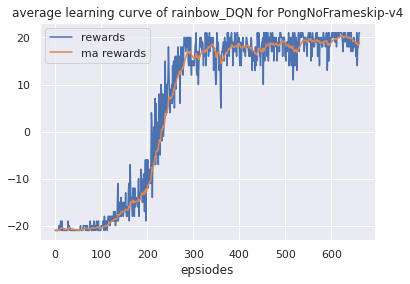

Start Evaluating!
20210707-103741
[20210707-103748: rainbow_DQN] Episode:1: Frame:1585.0: Reward:21.0
[20210707-103748: rainbow_DQN] Episode:3: Frame:4839.0: Reward:21.0
[20210707-103748: rainbow_DQN] Episode:4: Frame:6502.0: Reward:20.0
[20210707-103756: rainbow_DQN] Episode:5: Frame:8084.0: Reward:21.0
[20210707-103756: rainbow_DQN] Episode:6: Frame:9666.0: Reward:21.0
[20210707-103756: rainbow_DQN] Episode:7: Frame:11250.0: Reward:21.0
[20210707-103756: rainbow_DQN] Episode:8: Frame:12910.0: Reward:20.0
[20210707-103804: rainbow_DQN] Episode:9: Frame:14495.0: Reward:21.0
[20210707-103804: rainbow_DQN] Episode:10: Frame:16126.0: Reward:21.0
[20210707-103805: rainbow_DQN] Episode:11: Frame:17829.0: Reward:19.0
[20210707-103805: rainbow_DQN] Episode:12: Frame:19460.0: Reward:21.0
[20210707-103812: rainbow_DQN] Episode:13: Frame:21123.0: Reward:20.0
[20210707-103813: rainbow_DQN] Episode:14: Frame:22709.0: Reward:21.0
[20210707-103813: rainbow_DQN] Episode:15: Frame:24412.0: Reward:19.0

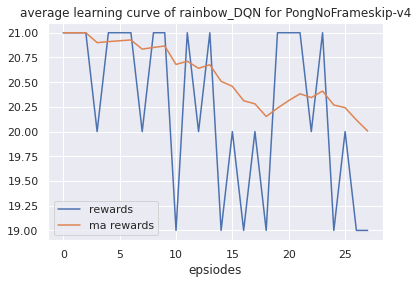

In [20]:
main()

In [ ]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'rainbow_DQN'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 8           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 1.2e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 300*2  # number of experience stored in memory before learning
        self.PER_alpha = 0.6                      # alpha for Prioritized Experience Replay, 0 - no importance sampling (IS); 1 - most IS 
        self.PER_beta = 0.4                       # beta for Prioritized Experience Replay, 0 - no annealing the bias from IS; 1 - Annealing the bias from IS 
        self.PER_beta_decay_method = None #'Linear'     # if None: no decay for PER beta
        self.PER_beta_decay = 1/self.memory_size/2  # decay rate for PER beta
        self.learn_freq = 2            # number of steps for one learning 
        self.sync_target_freq = 100     # number of learning steps for sync target model
        self.batch_size = 128*4          # number of examples in one batch
        self.lr = 0.0002                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.n_multi_step = 2          # number of steps of multi-step style gain 
        self.epsilon_start = 0.90      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.001        # ending epsilon
        self.epsilon_decay = 1/5000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'RainbowCNN'             # name of model
        self.Vmin = -10                 # lower bound of the uniform distribution of the categories
        self.Vmax = 10                  # upper bound of the uniform distribution of the categories
        self.num_atoms = 51             # number of classes in the uniform distribution of the categories
        self.hidden_dim = 512           # dimmension of hidden layer
        self.noisy_std = 0.5            # standard devision for noisy net 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

rainbow_DQN PongNoFrameskip-v4
Start Training!
20210706-135136
[20210706-135145: rainbow_DQN] Episode:1: Frame:755.0: Reward:-21.0: Loss:14.4838
[20210706-135148: rainbow_DQN] Episode:3: Frame:2332.0: Reward:-21.0: Loss:15.2345
[20210706-135156: rainbow_DQN] Episode:5: Frame:4224.0: Reward:-19.0: Loss:15.2069
[20210706-135156: rainbow_DQN] Episode:6: Frame:5241.0: Reward:-19.0: Loss:14.3398
[20210706-135157: rainbow_DQN] Episode:7: Frame:6286.0: Reward:-20.0: Loss:20.8144
[20210706-135157: rainbow_DQN] Episode:8: Frame:7339.0: Reward:-19.0: Loss:16.2807
[20210706-135221: rainbow_DQN] Episode:10: Frame:9021.0: Reward:-21.0: Loss:16.6055
[20210706-135226: rainbow_DQN] Episode:12: Frame:10772.0: Reward:-19.0: Loss:16.0289
[20210706-135231: rainbow_DQN] Episode:14: Frame:12349.0: Reward:-21.0: Loss:16.4086
[20210706-135239: rainbow_DQN] Episode:16: Frame:14277.0: Reward:-20.0: Loss:16.1460
[20210706-135254: rainbow_DQN] Episode:18: Frame:15868.0: Reward:-21.0: Loss:15.3198
[20210706-135257

[20210706-140644: rainbow_DQN] Episode:128: Frame:156282.0: Reward:-14.0: Loss:11.7389
[20210706-140720: rainbow_DQN] Episode:129: Frame:158104.0: Reward:-13.0: Loss:11.8897
[20210706-140726: rainbow_DQN] Episode:130: Frame:160053.0: Reward:-12.0: Loss:12.1864
[20210706-140729: rainbow_DQN] Episode:131: Frame:162321.0: Reward:-11.0: Loss:11.8913
[20210706-140736: rainbow_DQN] Episode:132: Frame:164244.0: Reward:-15.0: Loss:11.9677
[20210706-140752: rainbow_DQN] Episode:133: Frame:166443.0: Reward:-15.0: Loss:11.8455
[20210706-140814: rainbow_DQN] Episode:134: Frame:168914.0: Reward:-11.0: Loss:11.9073
[20210706-140818: rainbow_DQN] Episode:135: Frame:170787.0: Reward:-15.0: Loss:11.7232
[20210706-140822: rainbow_DQN] Episode:136: Frame:172915.0: Reward:-14.0: Loss:11.9882
[20210706-140908: rainbow_DQN] Episode:137: Frame:174864.0: Reward:-14.0: Loss:11.8168
[20210706-140916: rainbow_DQN] Episode:138: Frame:177152.0: Reward:-12.0: Loss:11.7779
[20210706-140926: rainbow_DQN] Episode:139:

[20210706-143018: rainbow_DQN] Episode:224: Frame:400340.0: Reward:8.0: Loss:11.6257
[20210706-143101: rainbow_DQN] Episode:225: Frame:402336.0: Reward:16.0: Loss:11.5422
[20210706-143105: rainbow_DQN] Episode:226: Frame:404204.0: Reward:19.0: Loss:11.7309
[20210706-143113: rainbow_DQN] Episode:227: Frame:405918.0: Reward:20.0: Loss:11.6588
[20210706-143133: rainbow_DQN] Episode:228: Frame:408215.0: Reward:13.0: Loss:11.6188
[20210706-143145: rainbow_DQN] Episode:229: Frame:410487.0: Reward:13.0: Loss:11.3755
[20210706-143151: rainbow_DQN] Episode:230: Frame:413081.0: Reward:7.0: Loss:11.7182
[20210706-143158: rainbow_DQN] Episode:231: Frame:415329.0: Reward:15.0: Loss:11.4840
[20210706-143211: rainbow_DQN] Episode:232: Frame:417624.0: Reward:16.0: Loss:11.7858
[20210706-143227: rainbow_DQN] Episode:233: Frame:419447.0: Reward:18.0: Loss:11.4367
[20210706-143252: rainbow_DQN] Episode:234: Frame:421596.0: Reward:15.0: Loss:11.4320
[20210706-143256: rainbow_DQN] Episode:235: Frame:424002

[20210706-144850: rainbow_DQN] Episode:320: Frame:588455.0: Reward:13.0: Loss:10.9409
[20210706-144852: rainbow_DQN] Episode:321: Frame:590630.0: Reward:16.0: Loss:10.6030
[20210706-144853: rainbow_DQN] Episode:322: Frame:592609.0: Reward:15.0: Loss:10.7421
[20210706-144926: rainbow_DQN] Episode:323: Frame:594477.0: Reward:17.0: Loss:10.8634
[20210706-144934: rainbow_DQN] Episode:324: Frame:596576.0: Reward:16.0: Loss:10.9146
[20210706-144959: rainbow_DQN] Episode:325: Frame:598269.0: Reward:20.0: Loss:11.0320
[20210706-145000: rainbow_DQN] Episode:326: Frame:600132.0: Reward:17.0: Loss:10.8955
[20210706-145000: rainbow_DQN] Episode:327: Frame:602159.0: Reward:16.0: Loss:10.8856
[20210706-145008: rainbow_DQN] Episode:328: Frame:603872.0: Reward:20.0: Loss:11.1189
[20210706-145011: rainbow_DQN] Episode:329: Frame:605661.0: Reward:18.0: Loss:10.8396
[20210706-145014: rainbow_DQN] Episode:330: Frame:607556.0: Reward:17.0: Loss:10.7099
[20210706-145046: rainbow_DQN] Episode:331: Frame:6092

[20210706-150506: rainbow_DQN] Episode:416: Frame:764045.0: Reward:17.0: Loss:10.9200
[20210706-150513: rainbow_DQN] Episode:417: Frame:766454.0: Reward:12.0: Loss:10.8521
[20210706-150514: rainbow_DQN] Episode:418: Frame:768154.0: Reward:20.0: Loss:10.7290
[20210706-150538: rainbow_DQN] Episode:419: Frame:769919.0: Reward:18.0: Loss:10.9515
[20210706-150550: rainbow_DQN] Episode:420: Frame:771561.0: Reward:21.0: Loss:10.6591
[20210706-150607: rainbow_DQN] Episode:421: Frame:773202.0: Reward:21.0: Loss:10.6468
[20210706-150610: rainbow_DQN] Episode:422: Frame:774805.0: Reward:21.0: Loss:10.6315
[20210706-150619: rainbow_DQN] Episode:423: Frame:776509.0: Reward:19.0: Loss:10.9671
[20210706-150621: rainbow_DQN] Episode:424: Frame:778100.0: Reward:21.0: Loss:10.8391
[20210706-150624: rainbow_DQN] Episode:425: Frame:779703.0: Reward:21.0: Loss:10.7175
[20210706-150628: rainbow_DQN] Episode:426: Frame:781648.0: Reward:11.0: Loss:10.8700
[20210706-150652: rainbow_DQN] Episode:427: Frame:7832

[20210706-152042: rainbow_DQN] Episode:512: Frame:935684.0: Reward:19.0: Loss:11.1501
[20210706-152045: rainbow_DQN] Episode:513: Frame:937515.0: Reward:19.0: Loss:10.7811
[20210706-152048: rainbow_DQN] Episode:514: Frame:939607.0: Reward:16.0: Loss:10.8985
[20210706-152125: rainbow_DQN] Episode:515: Frame:941260.0: Reward:21.0: Loss:10.8843
[20210706-152132: rainbow_DQN] Episode:516: Frame:942902.0: Reward:21.0: Loss:11.1878
[20210706-152145: rainbow_DQN] Episode:517: Frame:944585.0: Reward:20.0: Loss:10.8563
[20210706-152145: rainbow_DQN] Episode:518: Frame:946283.0: Reward:20.0: Loss:10.7574
[20210706-152148: rainbow_DQN] Episode:519: Frame:947938.0: Reward:21.0: Loss:10.9253
[20210706-152157: rainbow_DQN] Episode:520: Frame:949652.0: Reward:20.0: Loss:11.0634
[20210706-152158: rainbow_DQN] Episode:521: Frame:951242.0: Reward:21.0: Loss:10.8300
[20210706-152211: rainbow_DQN] Episode:522: Frame:953213.0: Reward:17.0: Loss:11.1175
[20210706-152233: rainbow_DQN] Episode:523: Frame:9548

[20210706-153606: rainbow_DQN] Episode:607: Frame:1103516.0: Reward:15.0: Loss:10.7781
[20210706-153616: rainbow_DQN] Episode:608: Frame:1105472.0: Reward:18.0: Loss:10.7781
[20210706-153644: rainbow_DQN] Episode:609: Frame:1107339.0: Reward:18.0: Loss:10.8084
[20210706-153647: rainbow_DQN] Episode:610: Frame:1109131.0: Reward:20.0: Loss:10.7205
[20210706-153657: rainbow_DQN] Episode:611: Frame:1111052.0: Reward:17.0: Loss:10.7217
[20210706-153658: rainbow_DQN] Episode:612: Frame:1112801.0: Reward:19.0: Loss:10.6211
[20210706-153707: rainbow_DQN] Episode:613: Frame:1114511.0: Reward:19.0: Loss:10.8371
[20210706-153715: rainbow_DQN] Episode:614: Frame:1116366.0: Reward:18.0: Loss:10.7731
[20210706-153724: rainbow_DQN] Episode:615: Frame:1118131.0: Reward:20.0: Loss:10.9141
[20210706-153728: rainbow_DQN] Episode:616: Frame:1119736.0: Reward:21.0: Loss:10.5577
[20210706-153757: rainbow_DQN] Episode:617: Frame:1121376.0: Reward:21.0: Loss:10.8190
[20210706-153801: rainbow_DQN] Episode:618:

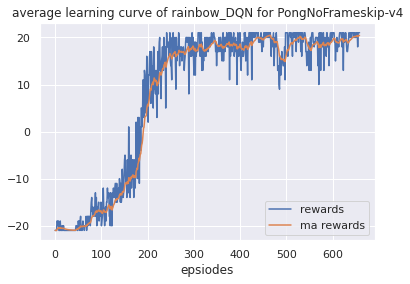

Start Evaluating!
20210706-154442
[20210706-154450: rainbow_DQN] Episode:2: Frame:3178.0: Reward:21.0
[20210706-154451: rainbow_DQN] Episode:3: Frame:4780.0: Reward:21.0
[20210706-154451: rainbow_DQN] Episode:4: Frame:6434.0: Reward:21.0
[20210706-154459: rainbow_DQN] Episode:5: Frame:8033.0: Reward:21.0
[20210706-154459: rainbow_DQN] Episode:6: Frame:9684.0: Reward:21.0
[20210706-154459: rainbow_DQN] Episode:7: Frame:11337.0: Reward:21.0
[20210706-154459: rainbow_DQN] Episode:8: Frame:12988.0: Reward:21.0
[20210706-154507: rainbow_DQN] Episode:9: Frame:14581.0: Reward:21.0
[20210706-154507: rainbow_DQN] Episode:10: Frame:16224.0: Reward:21.0
[20210706-154507: rainbow_DQN] Episode:11: Frame:17878.0: Reward:21.0
[20210706-154508: rainbow_DQN] Episode:12: Frame:19471.0: Reward:21.0
[20210706-154515: rainbow_DQN] Episode:13: Frame:21075.0: Reward:21.0
[20210706-154516: rainbow_DQN] Episode:14: Frame:22677.0: Reward:21.0
[20210706-154516: rainbow_DQN] Episode:15: Frame:24332.0: Reward:21.0

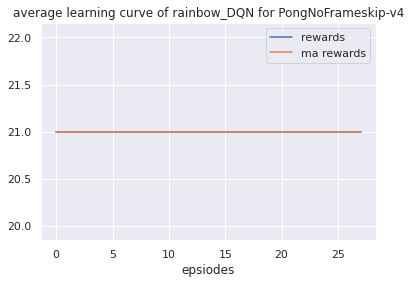

In [16]:
main()

# Multi-Step_DQN

In [9]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'DQN'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 8           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 1.2e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 300*2  # number of experience stored in memory before learning
        self.PER_alpha = 0.6                      # alpha for Prioritized Experience Replay, 0 - no importance sampling (IS); 1 - most IS 
        self.PER_beta = 0.4                       # beta for Prioritized Experience Replay, 0 - no annealing the bias from IS; 1 - Annealing the bias from IS 
        self.PER_beta_decay_method = None #'Linear'     # if None: no decay for PER beta
        self.PER_beta_decay = 1/self.memory_size/2  # decay rate for PER beta
        self.learn_freq = 2            # number of steps for one learning 
        self.sync_target_freq = 16     # number of learning steps for sync target model
        self.batch_size = 128*4          # number of examples in one batch
        self.lr = 0.0002                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.n_multi_step = 2          # number of steps of multi-step style gain 
        self.epsilon_start = 0.98      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.01        # ending epsilon
        self.epsilon_decay = 1/5000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'CNN'             # name of model
        self.Vmin = -10                 # lower bound of the uniform distribution of the categories
        self.Vmax = 10                  # upper bound of the uniform distribution of the categories
        self.num_atoms = 51             # number of classes in the uniform distribution of the categories
        self.hidden_dim = 512           # dimmension of hidden layer
        self.noisy_std = 0.5            # standard devision for noisy net 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

DQN PongNoFrameskip-v4
Start Training!
20210703-173749
[20210703-173756: DQN] Episode:1: Frame:811.0: Reward:-21.0: Loss:0.0520
[20210703-173757: DQN] Episode:3: Frame:2506.0: Reward:-21.0: Loss:0.0562
[20210703-173759: DQN] Episode:5: Frame:4390.0: Reward:-20.0: Loss:0.0328
[20210703-173800: DQN] Episode:7: Frame:6365.0: Reward:-19.0: Loss:0.0392
[20210703-173802: DQN] Episode:8: Frame:7455.0: Reward:-20.0: Loss:0.0216
[20210703-173816: DQN] Episode:10: Frame:9093.0: Reward:-21.0: Loss:0.0396
[20210703-173817: DQN] Episode:12: Frame:10878.0: Reward:-21.0: Loss:0.0314
[20210703-173819: DQN] Episode:14: Frame:12686.0: Reward:-21.0: Loss:0.0490
[20210703-173820: DQN] Episode:15: Frame:13700.0: Reward:-20.0: Loss:0.0432
[20210703-173822: DQN] Episode:16: Frame:14944.0: Reward:-18.0: Loss:0.0369
[20210703-173835: DQN] Episode:18: Frame:16693.0: Reward:-21.0: Loss:0.0892
[20210703-173838: DQN] Episode:20: Frame:18785.0: Reward:-18.0: Loss:0.0514
[20210703-173840: DQN] Episode:22: Frame:2078

[20210703-174535: DQN] Episode:122: Frame:163734.0: Reward:-15.0: Loss:0.0209
[20210703-174547: DQN] Episode:123: Frame:165786.0: Reward:-14.0: Loss:0.0174
[20210703-174556: DQN] Episode:124: Frame:167479.0: Reward:-19.0: Loss:0.0183
[20210703-174611: DQN] Episode:125: Frame:168943.0: Reward:-18.0: Loss:0.0190
[20210703-174614: DQN] Episode:126: Frame:171063.0: Reward:-19.0: Loss:0.0152
[20210703-174615: DQN] Episode:127: Frame:173113.0: Reward:-15.0: Loss:0.0157
[20210703-174616: DQN] Episode:128: Frame:174942.0: Reward:-16.0: Loss:0.0173
[20210703-174627: DQN] Episode:129: Frame:177424.0: Reward:-13.0: Loss:0.0231
[20210703-174632: DQN] Episode:130: Frame:179612.0: Reward:-12.0: Loss:0.0186
[20210703-174639: DQN] Episode:131: Frame:181544.0: Reward:-18.0: Loss:0.0183
[20210703-174645: DQN] Episode:132: Frame:183341.0: Reward:-16.0: Loss:0.0144
[20210703-174700: DQN] Episode:133: Frame:184986.0: Reward:-15.0: Loss:0.0120
[20210703-174711: DQN] Episode:134: Frame:187078.0: Reward:-15.0

[20210703-180318: DQN] Episode:228: Frame:435347.0: Reward:8.0: Loss:0.0092
[20210703-180320: DQN] Episode:229: Frame:437556.0: Reward:13.0: Loss:0.0127
[20210703-180325: DQN] Episode:230: Frame:439708.0: Reward:14.0: Loss:0.0130
[20210703-180343: DQN] Episode:231: Frame:442227.0: Reward:10.0: Loss:0.0112
[20210703-180410: DQN] Episode:232: Frame:445408.0: Reward:5.0: Loss:0.0174
[20210703-180413: DQN] Episode:233: Frame:447554.0: Reward:16.0: Loss:0.0145
[20210703-180421: DQN] Episode:234: Frame:449223.0: Reward:20.0: Loss:0.0183
[20210703-180428: DQN] Episode:235: Frame:452240.0: Reward:7.0: Loss:0.0137
[20210703-180442: DQN] Episode:236: Frame:454698.0: Reward:13.0: Loss:0.0122
[20210703-180448: DQN] Episode:237: Frame:457200.0: Reward:11.0: Loss:0.0108
[20210703-180452: DQN] Episode:238: Frame:459603.0: Reward:13.0: Loss:0.0167
[20210703-180459: DQN] Episode:239: Frame:461690.0: Reward:13.0: Loss:0.0119
[20210703-180526: DQN] Episode:240: Frame:463676.0: Reward:18.0: Loss:0.0113
[2

[20210703-182052: DQN] Episode:335: Frame:652865.0: Reward:18.0: Loss:0.0083
[20210703-182058: DQN] Episode:336: Frame:655114.0: Reward:14.0: Loss:0.0135
[20210703-182113: DQN] Episode:337: Frame:656862.0: Reward:20.0: Loss:0.0142
[20210703-182127: DQN] Episode:338: Frame:658695.0: Reward:19.0: Loss:0.0084
[20210703-182137: DQN] Episode:339: Frame:660852.0: Reward:18.0: Loss:0.0108
[20210703-182217: DQN] Episode:340: Frame:662705.0: Reward:19.0: Loss:0.0138
[20210703-182217: DQN] Episode:341: Frame:664490.0: Reward:20.0: Loss:0.0076
[20210703-182221: DQN] Episode:342: Frame:666610.0: Reward:15.0: Loss:0.0089
[20210703-182226: DQN] Episode:343: Frame:668438.0: Reward:19.0: Loss:0.0264
[20210703-182232: DQN] Episode:344: Frame:670106.0: Reward:20.0: Loss:0.0211
[20210703-182235: DQN] Episode:345: Frame:672548.0: Reward:13.0: Loss:0.0092
[20210703-182249: DQN] Episode:346: Frame:674254.0: Reward:19.0: Loss:0.0079
[20210703-182304: DQN] Episode:347: Frame:676096.0: Reward:18.0: Loss:0.0120

[20210703-184023: DQN] Episode:443: Frame:852433.0: Reward:21.0: Loss:0.0065
[20210703-184059: DQN] Episode:444: Frame:854088.0: Reward:21.0: Loss:0.0107
[20210703-184105: DQN] Episode:445: Frame:855806.0: Reward:20.0: Loss:0.0075
[20210703-184109: DQN] Episode:446: Frame:857523.0: Reward:20.0: Loss:0.0092
[20210703-184116: DQN] Episode:447: Frame:859271.0: Reward:19.0: Loss:0.0069
[20210703-184126: DQN] Episode:448: Frame:860898.0: Reward:21.0: Loss:0.0113
[20210703-184130: DQN] Episode:449: Frame:862534.0: Reward:21.0: Loss:0.0070
[20210703-184137: DQN] Episode:450: Frame:864820.0: Reward:16.0: Loss:0.0048
[20210703-184144: DQN] Episode:451: Frame:866553.0: Reward:20.0: Loss:0.0093
[20210703-184219: DQN] Episode:452: Frame:868233.0: Reward:20.0: Loss:0.0117
[20210703-184228: DQN] Episode:453: Frame:869963.0: Reward:20.0: Loss:0.0103
[20210703-184234: DQN] Episode:454: Frame:871595.0: Reward:21.0: Loss:0.0056
[20210703-184238: DQN] Episode:455: Frame:873441.0: Reward:18.0: Loss:0.0097

[20210703-190006: DQN] Episode:551: Frame:1046703.0: Reward:15.0: Loss:0.0042
[20210703-190030: DQN] Episode:552: Frame:1048437.0: Reward:19.0: Loss:0.0033
[20210703-190031: DQN] Episode:553: Frame:1050069.0: Reward:21.0: Loss:0.0031
[20210703-190040: DQN] Episode:554: Frame:1052026.0: Reward:18.0: Loss:0.0070
[20210703-190046: DQN] Episode:555: Frame:1053867.0: Reward:19.0: Loss:0.0058
[20210703-190046: DQN] Episode:556: Frame:1055643.0: Reward:19.0: Loss:0.0067
[20210703-190124: DQN] Episode:557: Frame:1057358.0: Reward:20.0: Loss:0.0055
[20210703-190127: DQN] Episode:558: Frame:1059132.0: Reward:20.0: Loss:0.0072
[20210703-190129: DQN] Episode:559: Frame:1060850.0: Reward:21.0: Loss:0.0045
[20210703-190153: DQN] Episode:560: Frame:1062570.0: Reward:20.0: Loss:0.0048
[20210703-190156: DQN] Episode:561: Frame:1064345.0: Reward:19.0: Loss:0.0058
[20210703-190201: DQN] Episode:562: Frame:1066035.0: Reward:20.0: Loss:0.0035
[20210703-190206: DQN] Episode:563: Frame:1067676.0: Reward:21.0

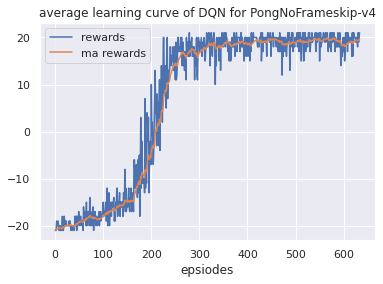

Start Evaluating!
20210703-191507
[20210703-191514: DQN] Episode:1: Frame:1633.0: Reward:21.0
[20210703-191514: DQN] Episode:3: Frame:5117.0: Reward:20.0
[20210703-191515: DQN] Episode:4: Frame:6921.0: Reward:20.0
[20210703-191520: DQN] Episode:5: Frame:8551.0: Reward:21.0
[20210703-191521: DQN] Episode:6: Frame:10181.0: Reward:21.0
[20210703-191521: DQN] Episode:7: Frame:11813.0: Reward:21.0
[20210703-191522: DQN] Episode:8: Frame:13614.0: Reward:20.0
[20210703-191528: DQN] Episode:9: Frame:15247.0: Reward:21.0
[20210703-191528: DQN] Episode:10: Frame:16993.0: Reward:20.0
[20210703-191529: DQN] Episode:11: Frame:18899.0: Reward:19.0
[20210703-191529: DQN] Episode:12: Frame:20645.0: Reward:20.0
[20210703-191535: DQN] Episode:13: Frame:22449.0: Reward:20.0
[20210703-191535: DQN] Episode:14: Frame:24083.0: Reward:21.0
[20210703-191535: DQN] Episode:15: Frame:25989.0: Reward:19.0
[20210703-191536: DQN] Episode:16: Frame:27795.0: Reward:20.0
[20210703-191542: DQN] Episode:17: Frame:29700.0

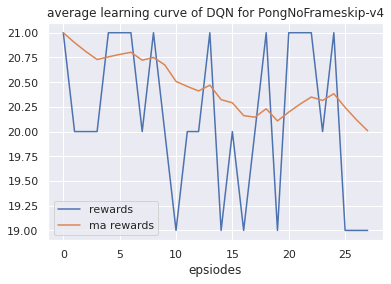

In [15]:
main()

# Categorical_DQN

In [9]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'ctegorical_DQN'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 8           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.train_eps = 700           # number of training episodes
        self.eval_eps = 50            # number of evaluation episodes
        self.max_train_frames = 1.8e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 300*2  # number of experience stored in memory before learning
        self.PER_alpha = 0.6                      # alpha for Prioritized Experience Replay, 0 - no importance sampling (IS); 1 - most IS 
        self.PER_beta = 0.4                       # beta for Prioritized Experience Replay, 0 - no annealing the bias from IS; 1 - Annealing the bias from IS 
        self.PER_beta_decay_method = None #'Linear'     # if None: no decay for PER beta
        self.PER_beta_decay = 1/self.memory_size/2  # decay rate for PER beta
        self.learn_freq = 2            # number of steps for one learning 
        self.sync_target_freq = 16     # number of learning steps for sync target model
        self.batch_size = 128*4          # number of examples in one batch
        self.lr = 0.0002                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.n_multi_step = 1          # number of steps of multi-step style gain 
        self.epsilon_start = 0.98      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.01        # ending epsilon
        self.epsilon_decay = 1/5000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'CategoricalCNN'             # name of model
        self.Vmin = -10                 # lower bound of the uniform distribution of the categories
        self.Vmax = 10                  # upper bound of the uniform distribution of the categories
        self.num_atoms = 51             # number of classes in the uniform distribution of the categories
        self.hidden_dim = 512           # dimmension of hidden layer
        self.noisy_std = 0.5            # standard devision for noisy net 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

ctegorical_DQN PongNoFrameskip-v4
Start Training!
20210702-094657
[20210702-094705: ctegorical_DQN] Episode:1: Frame:817.0: Reward:-21.0: Loss:17.0161
[20210702-094706: ctegorical_DQN] Episode:3: Frame:2497.0: Reward:-21.0: Loss:16.7059
[20210702-094709: ctegorical_DQN] Episode:5: Frame:4426.0: Reward:-21.0: Loss:16.3320
[20210702-094709: ctegorical_DQN] Episode:7: Frame:6389.0: Reward:-20.0: Loss:16.3846
[20210702-094724: ctegorical_DQN] Episode:9: Frame:8143.0: Reward:-21.0: Loss:15.6038
[20210702-094729: ctegorical_DQN] Episode:11: Frame:9792.0: Reward:-20.0: Loss:15.6984
[20210702-094730: ctegorical_DQN] Episode:13: Frame:11455.0: Reward:-21.0: Loss:15.4425
[20210702-094730: ctegorical_DQN] Episode:15: Frame:13367.0: Reward:-19.0: Loss:15.5207
[20210702-094736: ctegorical_DQN] Episode:16: Frame:14465.0: Reward:-20.0: Loss:15.7605
[20210702-094747: ctegorical_DQN] Episode:18: Frame:16284.0: Reward:-20.0: Loss:15.6017
[20210702-094750: ctegorical_DQN] Episode:20: Frame:17936.0: Rewar

[20210702-095427: ctegorical_DQN] Episode:114: Frame:146230.0: Reward:-16.0: Loss:15.9527
[20210702-095438: ctegorical_DQN] Episode:115: Frame:147952.0: Reward:-15.0: Loss:15.8967
[20210702-095450: ctegorical_DQN] Episode:116: Frame:149743.0: Reward:-18.0: Loss:15.8770
[20210702-095452: ctegorical_DQN] Episode:117: Frame:151834.0: Reward:-13.0: Loss:15.8965
[20210702-095458: ctegorical_DQN] Episode:118: Frame:153642.0: Reward:-16.0: Loss:15.8941
[20210702-095458: ctegorical_DQN] Episode:119: Frame:155193.0: Reward:-19.0: Loss:15.9172
[20210702-095502: ctegorical_DQN] Episode:120: Frame:156974.0: Reward:-16.0: Loss:15.9647
[20210702-095503: ctegorical_DQN] Episode:121: Frame:158424.0: Reward:-19.0: Loss:16.0998
[20210702-095509: ctegorical_DQN] Episode:122: Frame:160509.0: Reward:-13.0: Loss:16.0511
[20210702-095523: ctegorical_DQN] Episode:123: Frame:162316.0: Reward:-16.0: Loss:15.8050
[20210702-095533: ctegorical_DQN] Episode:124: Frame:163986.0: Reward:-14.0: Loss:15.9784
[20210702-

[20210702-100459: ctegorical_DQN] Episode:207: Frame:344722.0: Reward:-9.0: Loss:15.9767
[20210702-100505: ctegorical_DQN] Episode:208: Frame:347321.0: Reward:-11.0: Loss:16.2549
[20210702-100507: ctegorical_DQN] Episode:209: Frame:350044.0: Reward:-12.0: Loss:16.1348
[20210702-100521: ctegorical_DQN] Episode:210: Frame:352608.0: Reward:-12.0: Loss:15.9045
[20210702-100521: ctegorical_DQN] Episode:211: Frame:355814.0: Reward:-6.0: Loss:15.9139
[20210702-100528: ctegorical_DQN] Episode:212: Frame:358620.0: Reward:-11.0: Loss:15.9707
[20210702-100540: ctegorical_DQN] Episode:213: Frame:360603.0: Reward:-15.0: Loss:15.9579
[20210702-100606: ctegorical_DQN] Episode:214: Frame:363009.0: Reward:-8.0: Loss:15.9353
[20210702-100608: ctegorical_DQN] Episode:215: Frame:366075.0: Reward:-8.0: Loss:15.9404
[20210702-100611: ctegorical_DQN] Episode:216: Frame:368941.0: Reward:-9.0: Loss:15.8077
[20210702-100615: ctegorical_DQN] Episode:217: Frame:371081.0: Reward:-15.0: Loss:15.9228
[20210702-10061

[20210702-101831: ctegorical_DQN] Episode:299: Frame:614756.0: Reward:-10.0: Loss:16.0483
[20210702-101841: ctegorical_DQN] Episode:300: Frame:618436.0: Reward:1.0: Loss:15.9916
[20210702-101902: ctegorical_DQN] Episode:301: Frame:622088.0: Reward:1.0: Loss:15.7212
[20210702-101904: ctegorical_DQN] Episode:302: Frame:625051.0: Reward:-11.0: Loss:15.8758
[20210702-101915: ctegorical_DQN] Episode:303: Frame:628135.0: Reward:-3.0: Loss:16.0230
[20210702-101922: ctegorical_DQN] Episode:304: Frame:630243.0: Reward:-14.0: Loss:16.2212
[20210702-101931: ctegorical_DQN] Episode:305: Frame:633605.0: Reward:5.0: Loss:16.0527
[20210702-101938: ctegorical_DQN] Episode:306: Frame:636929.0: Reward:-4.0: Loss:16.1784
[20210702-101941: ctegorical_DQN] Episode:307: Frame:639410.0: Reward:12.0: Loss:15.9900
[20210702-101952: ctegorical_DQN] Episode:308: Frame:642720.0: Reward:2.0: Loss:15.6828
[20210702-102012: ctegorical_DQN] Episode:309: Frame:645652.0: Reward:-6.0: Loss:15.7660
[20210702-102036: cteg

[20210702-103306: ctegorical_DQN] Episode:392: Frame:905113.0: Reward:1.0: Loss:15.8957
[20210702-103340: ctegorical_DQN] Episode:393: Frame:908938.0: Reward:-1.0: Loss:15.8864
[20210702-103341: ctegorical_DQN] Episode:394: Frame:912424.0: Reward:3.0: Loss:15.8987
[20210702-103344: ctegorical_DQN] Episode:395: Frame:915853.0: Reward:6.0: Loss:15.9307
[20210702-103353: ctegorical_DQN] Episode:396: Frame:919614.0: Reward:2.0: Loss:16.0083
[20210702-103408: ctegorical_DQN] Episode:397: Frame:923167.0: Reward:-2.0: Loss:15.9895
[20210702-103409: ctegorical_DQN] Episode:398: Frame:926627.0: Reward:3.0: Loss:16.0389
[20210702-103420: ctegorical_DQN] Episode:399: Frame:929751.0: Reward:-4.0: Loss:16.0504
[20210702-103430: ctegorical_DQN] Episode:400: Frame:933344.0: Reward:-3.0: Loss:16.1552
[20210702-103501: ctegorical_DQN] Episode:401: Frame:936793.0: Reward:-5.0: Loss:16.2177
[20210702-103501: ctegorical_DQN] Episode:402: Frame:940243.0: Reward:-4.0: Loss:16.2096
[20210702-103509: ctegoric

[20210702-104719: ctegorical_DQN] Episode:484: Frame:1184406.0: Reward:10.0: Loss:15.8610
[20210702-104719: ctegorical_DQN] Episode:485: Frame:1186702.0: Reward:14.0: Loss:15.8915
[20210702-104719: ctegorical_DQN] Episode:486: Frame:1189093.0: Reward:11.0: Loss:15.8709
[20210702-104729: ctegorical_DQN] Episode:487: Frame:1192440.0: Reward:4.0: Loss:15.6799
[20210702-104729: ctegorical_DQN] Episode:488: Frame:1194706.0: Reward:15.0: Loss:15.6714
[20210702-104742: ctegorical_DQN] Episode:489: Frame:1197869.0: Reward:3.0: Loss:16.1358
[20210702-104745: ctegorical_DQN] Episode:490: Frame:1201089.0: Reward:-8.0: Loss:16.3029
[20210702-104815: ctegorical_DQN] Episode:491: Frame:1203830.0: Reward:13.0: Loss:16.1219
[20210702-104815: ctegorical_DQN] Episode:492: Frame:1206237.0: Reward:10.0: Loss:16.1262
[20210702-104816: ctegorical_DQN] Episode:493: Frame:1208638.0: Reward:11.0: Loss:16.0789
[20210702-104827: ctegorical_DQN] Episode:494: Frame:1211539.0: Reward:8.0: Loss:15.8797
[20210702-104

[20210702-105812: ctegorical_DQN] Episode:576: Frame:1401903.0: Reward:18.0: Loss:15.9593
[20210702-105823: ctegorical_DQN] Episode:577: Frame:1404404.0: Reward:13.0: Loss:16.0840
[20210702-105830: ctegorical_DQN] Episode:578: Frame:1406779.0: Reward:12.0: Loss:16.1748
[20210702-105832: ctegorical_DQN] Episode:579: Frame:1409126.0: Reward:12.0: Loss:16.0762
[20210702-105832: ctegorical_DQN] Episode:580: Frame:1411062.0: Reward:16.0: Loss:16.0836
[20210702-105834: ctegorical_DQN] Episode:581: Frame:1413109.0: Reward:15.0: Loss:15.9722
[20210702-105846: ctegorical_DQN] Episode:582: Frame:1415104.0: Reward:15.0: Loss:15.8972
[20210702-105850: ctegorical_DQN] Episode:583: Frame:1417312.0: Reward:16.0: Loss:15.9083
[20210702-105914: ctegorical_DQN] Episode:584: Frame:1419326.0: Reward:16.0: Loss:16.0372
[20210702-105923: ctegorical_DQN] Episode:585: Frame:1421330.0: Reward:15.0: Loss:15.7329
[20210702-105923: ctegorical_DQN] Episode:586: Frame:1423411.0: Reward:15.0: Loss:15.7704
[20210702-

[20210702-110823: ctegorical_DQN] Episode:668: Frame:1594199.0: Reward:15.0: Loss:15.6927
[20210702-110834: ctegorical_DQN] Episode:669: Frame:1596940.0: Reward:12.0: Loss:15.8562
[20210702-110840: ctegorical_DQN] Episode:670: Frame:1598793.0: Reward:19.0: Loss:16.0271
[20210702-110849: ctegorical_DQN] Episode:671: Frame:1600937.0: Reward:15.0: Loss:15.9370
[20210702-110851: ctegorical_DQN] Episode:672: Frame:1603016.0: Reward:15.0: Loss:16.0028
[20210702-110851: ctegorical_DQN] Episode:673: Frame:1605012.0: Reward:19.0: Loss:15.9592
[20210702-110857: ctegorical_DQN] Episode:674: Frame:1608105.0: Reward:6.0: Loss:15.7671
[20210702-110859: ctegorical_DQN] Episode:675: Frame:1610318.0: Reward:14.0: Loss:15.8848
[20210702-110906: ctegorical_DQN] Episode:676: Frame:1612005.0: Reward:20.0: Loss:15.9392
[20210702-110917: ctegorical_DQN] Episode:677: Frame:1613696.0: Reward:20.0: Loss:15.8520
[20210702-110934: ctegorical_DQN] Episode:678: Frame:1615803.0: Reward:16.0: Loss:16.1910
[20210702-1

[20210702-111834: ctegorical_DQN] Episode:760: Frame:1786745.0: Reward:18.0: Loss:15.7929
[20210702-111839: ctegorical_DQN] Episode:761: Frame:1789163.0: Reward:13.0: Loss:15.7874
[20210702-111845: ctegorical_DQN] Episode:762: Frame:1790857.0: Reward:21.0: Loss:16.1074
results saved!


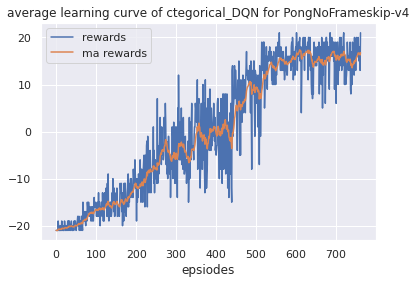

Start Evaluating!
20210702-111900
[20210702-111906: ctegorical_DQN] Episode:1: Frame:1646.0: Reward:21.0
[20210702-111906: ctegorical_DQN] Episode:2: Frame:3314.0: Reward:20.0
[20210702-111908: ctegorical_DQN] Episode:4: Frame:7254.0: Reward:18.0
[20210702-111914: ctegorical_DQN] Episode:5: Frame:8878.0: Reward:21.0
[20210702-111914: ctegorical_DQN] Episode:6: Frame:10543.0: Reward:20.0
[20210702-111915: ctegorical_DQN] Episode:7: Frame:12208.0: Reward:20.0
[20210702-111915: ctegorical_DQN] Episode:8: Frame:13875.0: Reward:20.0
[20210702-111922: ctegorical_DQN] Episode:9: Frame:15849.0: Reward:18.0
[20210702-111923: ctegorical_DQN] Episode:10: Frame:17517.0: Reward:20.0
[20210702-111923: ctegorical_DQN] Episode:11: Frame:19491.0: Reward:18.0
[20210702-111930: ctegorical_DQN] Episode:12: Frame:21139.0: Reward:21.0
[20210702-111930: ctegorical_DQN] Episode:13: Frame:22785.0: Reward:21.0
[20210702-111938: ctegorical_DQN] Episode:14: Frame:24758.0: Reward:18.0
[20210702-111947: ctegorical_

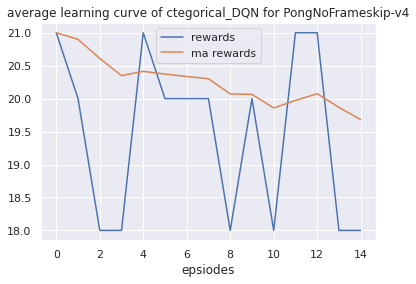

In [19]:
main()

# Noisy_DQN

In [12]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'noisy_DQN'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 8           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.train_eps = 700           # number of training episodes
        self.eval_eps = 50            # number of evaluation episodes
        self.max_train_frames = 1.8e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 300*2  # number of experience stored in memory before learning
        self.PER_alpha = 0.6                      # alpha for Prioritized Experience Replay, 0 - no importance sampling (IS); 1 - most IS 
        self.PER_beta = 0.4                       # beta for Prioritized Experience Replay, 0 - no annealing the bias from IS; 1 - Annealing the bias from IS 
        self.PER_beta_decay_method = None #'Linear'     # if None: no decay for PER beta
        self.PER_beta_decay = 1/self.memory_size/2  # decay rate for PER beta
        self.learn_freq = 2            # number of steps for one learning 
        self.sync_target_freq = 16     # number of learning steps for sync target model
        self.batch_size = 128*4          # number of examples in one batch
        self.lr = 0.0002                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.n_multi_step = 1          # number of steps of multi-step style gain 
        self.epsilon_start = 0.90      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.001        # ending epsilon
        self.epsilon_decay = 1/5000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'NoisyCNN'             # name of model
        self.hidden_dim = 512           # dimmension of hidden layer
        self.noisy_std = 0.5            # standard devision for noisy net 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

noisy_DQN PongNoFrameskip-v4
Start Training!
20210629-180927
[20210629-180934: noisy_DQN] Episode:1: Frame:755.0: Reward:-21.0: Loss:2.9243
[20210629-180937: noisy_DQN] Episode:3: Frame:2390.0: Reward:-21.0: Loss:17.1391
[20210629-180939: noisy_DQN] Episode:5: Frame:4271.0: Reward:-20.0: Loss:22.6895
[20210629-180941: noisy_DQN] Episode:7: Frame:6258.0: Reward:-21.0: Loss:39.6704
[20210629-180942: noisy_DQN] Episode:8: Frame:7315.0: Reward:-20.0: Loss:172.3306
[20210629-180958: noisy_DQN] Episode:10: Frame:8904.0: Reward:-21.0: Loss:652.7471
[20210629-181000: noisy_DQN] Episode:12: Frame:10743.0: Reward:-19.0: Loss:1457.5087
[20210629-181004: noisy_DQN] Episode:14: Frame:12672.0: Reward:-20.0: Loss:151.6334
[20210629-181007: noisy_DQN] Episode:15: Frame:13705.0: Reward:-19.0: Loss:380.3734
[20210629-181008: noisy_DQN] Episode:16: Frame:14734.0: Reward:-19.0: Loss:360.7128
[20210629-181021: noisy_DQN] Episode:18: Frame:16337.0: Reward:-21.0: Loss:58.4853
[20210629-181022: noisy_DQN] Epi

[20210629-181809: noisy_DQN] Episode:174: Frame:160502.0: Reward:-19.0: Loss:0.0403
[20210629-181812: noisy_DQN] Episode:176: Frame:162442.0: Reward:-20.0: Loss:0.0123
[20210629-181815: noisy_DQN] Episode:178: Frame:164461.0: Reward:-21.0: Loss:0.0236
[20210629-181820: noisy_DQN] Episode:179: Frame:165719.0: Reward:-18.0: Loss:0.0299
[20210629-181831: noisy_DQN] Episode:181: Frame:167537.0: Reward:-20.0: Loss:0.0269
[20210629-181833: noisy_DQN] Episode:183: Frame:169359.0: Reward:-20.0: Loss:0.0115
[20210629-181844: noisy_DQN] Episode:185: Frame:171482.0: Reward:-21.0: Loss:0.0153
[20210629-181850: noisy_DQN] Episode:186: Frame:172583.0: Reward:-20.0: Loss:0.0223
[20210629-181851: noisy_DQN] Episode:187: Frame:173921.0: Reward:-19.0: Loss:0.0125
[20210629-181857: noisy_DQN] Episode:188: Frame:175166.0: Reward:-17.0: Loss:0.0214
[20210629-181902: noisy_DQN] Episode:189: Frame:176302.0: Reward:-21.0: Loss:0.0171
[20210629-181903: noisy_DQN] Episode:191: Frame:178261.0: Reward:-19.0: Loss

[20210629-182809: noisy_DQN] Episode:281: Frame:335050.0: Reward:-9.0: Loss:0.0219
[20210629-182811: noisy_DQN] Episode:282: Frame:336920.0: Reward:-18.0: Loss:0.0178
[20210629-182827: noisy_DQN] Episode:283: Frame:339699.0: Reward:-9.0: Loss:0.0101
[20210629-182834: noisy_DQN] Episode:284: Frame:341982.0: Reward:-12.0: Loss:0.0170
[20210629-182834: noisy_DQN] Episode:285: Frame:344175.0: Reward:-14.0: Loss:0.0117
[20210629-182846: noisy_DQN] Episode:286: Frame:346524.0: Reward:-12.0: Loss:0.0170
[20210629-182852: noisy_DQN] Episode:287: Frame:349153.0: Reward:-9.0: Loss:0.0156
[20210629-182909: noisy_DQN] Episode:288: Frame:351311.0: Reward:-15.0: Loss:0.0196
[20210629-182910: noisy_DQN] Episode:289: Frame:353408.0: Reward:-14.0: Loss:0.0200
[20210629-182922: noisy_DQN] Episode:290: Frame:356279.0: Reward:-5.0: Loss:0.0166
[20210629-182929: noisy_DQN] Episode:291: Frame:358210.0: Reward:-17.0: Loss:0.0132
[20210629-182929: noisy_DQN] Episode:292: Frame:360381.0: Reward:-15.0: Loss:0.0

[20210629-184145: noisy_DQN] Episode:379: Frame:574239.0: Reward:-8.0: Loss:0.0134
[20210629-184145: noisy_DQN] Episode:380: Frame:577681.0: Reward:-2.0: Loss:0.0113
[20210629-184212: noisy_DQN] Episode:381: Frame:580888.0: Reward:-4.0: Loss:0.0132
[20210629-184215: noisy_DQN] Episode:382: Frame:583782.0: Reward:-6.0: Loss:0.0172
[20210629-184215: noisy_DQN] Episode:383: Frame:586901.0: Reward:7.0: Loss:0.0134
[20210629-184226: noisy_DQN] Episode:384: Frame:589479.0: Reward:-9.0: Loss:0.0086
[20210629-184235: noisy_DQN] Episode:385: Frame:592620.0: Reward:4.0: Loss:0.0105
[20210629-184250: noisy_DQN] Episode:386: Frame:595687.0: Reward:3.0: Loss:0.0096
[20210629-184255: noisy_DQN] Episode:387: Frame:598345.0: Reward:6.0: Loss:0.0248
[20210629-184310: noisy_DQN] Episode:388: Frame:601556.0: Reward:-2.0: Loss:0.0086
[20210629-184324: noisy_DQN] Episode:389: Frame:604148.0: Reward:9.0: Loss:0.0211
[20210629-184345: noisy_DQN] Episode:390: Frame:607661.0: Reward:-3.0: Loss:0.0143
[20210629

[20210629-185713: noisy_DQN] Episode:479: Frame:859079.0: Reward:10.0: Loss:0.0094
[20210629-185720: noisy_DQN] Episode:480: Frame:861884.0: Reward:6.0: Loss:0.0084
[20210629-185724: noisy_DQN] Episode:481: Frame:864358.0: Reward:11.0: Loss:0.0102
[20210629-185729: noisy_DQN] Episode:482: Frame:866409.0: Reward:15.0: Loss:0.0112
[20210629-185743: noisy_DQN] Episode:483: Frame:868468.0: Reward:18.0: Loss:0.0094
[20210629-185803: noisy_DQN] Episode:484: Frame:870473.0: Reward:19.0: Loss:0.0094
[20210629-185804: noisy_DQN] Episode:485: Frame:872418.0: Reward:19.0: Loss:0.0127
[20210629-185816: noisy_DQN] Episode:486: Frame:874412.0: Reward:17.0: Loss:0.0077
[20210629-185821: noisy_DQN] Episode:487: Frame:877048.0: Reward:12.0: Loss:0.0199
[20210629-185821: noisy_DQN] Episode:488: Frame:879039.0: Reward:16.0: Loss:0.0092
[20210629-185824: noisy_DQN] Episode:489: Frame:881500.0: Reward:12.0: Loss:0.0184
[20210629-185828: noisy_DQN] Episode:490: Frame:884650.0: Reward:10.0: Loss:0.0107
[2021

[20210629-191059: noisy_DQN] Episode:579: Frame:1109931.0: Reward:19.0: Loss:0.0077
[20210629-191104: noisy_DQN] Episode:580: Frame:1112299.0: Reward:11.0: Loss:0.0071
[20210629-191111: noisy_DQN] Episode:581: Frame:1114427.0: Reward:17.0: Loss:0.0086
[20210629-191121: noisy_DQN] Episode:582: Frame:1116779.0: Reward:14.0: Loss:0.0068
[20210629-191139: noisy_DQN] Episode:583: Frame:1118604.0: Reward:20.0: Loss:0.0096
[20210629-191140: noisy_DQN] Episode:584: Frame:1120416.0: Reward:19.0: Loss:0.0075
[20210629-191149: noisy_DQN] Episode:585: Frame:1122299.0: Reward:19.0: Loss:0.0067
[20210629-191149: noisy_DQN] Episode:586: Frame:1123974.0: Reward:20.0: Loss:0.0139
[20210629-191159: noisy_DQN] Episode:587: Frame:1126808.0: Reward:6.0: Loss:0.0106
[20210629-191159: noisy_DQN] Episode:588: Frame:1128588.0: Reward:20.0: Loss:0.0080
[20210629-191213: noisy_DQN] Episode:589: Frame:1131427.0: Reward:7.0: Loss:0.0077
[20210629-191224: noisy_DQN] Episode:590: Frame:1133771.0: Reward:15.0: Loss:0

[20210629-192223: noisy_DQN] Episode:677: Frame:1320302.0: Reward:20.0: Loss:0.0055
[20210629-192224: noisy_DQN] Episode:678: Frame:1322295.0: Reward:17.0: Loss:0.0065
[20210629-192239: noisy_DQN] Episode:679: Frame:1323971.0: Reward:20.0: Loss:0.0081
[20210629-192244: noisy_DQN] Episode:680: Frame:1326414.0: Reward:16.0: Loss:0.0049
[20210629-192248: noisy_DQN] Episode:681: Frame:1328388.0: Reward:19.0: Loss:0.0098
[20210629-192253: noisy_DQN] Episode:682: Frame:1330240.0: Reward:18.0: Loss:0.0055
[20210629-192255: noisy_DQN] Episode:683: Frame:1332613.0: Reward:13.0: Loss:0.0076
[20210629-192314: noisy_DQN] Episode:684: Frame:1334689.0: Reward:18.0: Loss:0.0080
[20210629-192316: noisy_DQN] Episode:685: Frame:1336807.0: Reward:17.0: Loss:0.0045
[20210629-192324: noisy_DQN] Episode:686: Frame:1339245.0: Reward:13.0: Loss:0.0065
[20210629-192324: noisy_DQN] Episode:687: Frame:1341096.0: Reward:18.0: Loss:0.0088
[20210629-192329: noisy_DQN] Episode:688: Frame:1342767.0: Reward:21.0: Loss

[20210629-193242: noisy_DQN] Episode:775: Frame:1516878.0: Reward:17.0: Loss:0.0056
[20210629-193248: noisy_DQN] Episode:776: Frame:1518854.0: Reward:18.0: Loss:0.0050
[20210629-193257: noisy_DQN] Episode:777: Frame:1520767.0: Reward:19.0: Loss:0.0111
[20210629-193300: noisy_DQN] Episode:778: Frame:1523219.0: Reward:18.0: Loss:0.0055
[20210629-193308: noisy_DQN] Episode:779: Frame:1525676.0: Reward:14.0: Loss:0.0117
[20210629-193323: noisy_DQN] Episode:780: Frame:1527690.0: Reward:18.0: Loss:0.0036
[20210629-193324: noisy_DQN] Episode:781: Frame:1529933.0: Reward:15.0: Loss:0.0040
[20210629-193333: noisy_DQN] Episode:782: Frame:1532279.0: Reward:16.0: Loss:0.0054
[20210629-193336: noisy_DQN] Episode:783: Frame:1534409.0: Reward:15.0: Loss:0.0060
[20210629-193346: noisy_DQN] Episode:784: Frame:1536396.0: Reward:18.0: Loss:0.0074
[20210629-193348: noisy_DQN] Episode:785: Frame:1538794.0: Reward:16.0: Loss:0.0041
[20210629-193355: noisy_DQN] Episode:786: Frame:1540992.0: Reward:15.0: Loss

[20210629-194300: noisy_DQN] Episode:873: Frame:1717598.0: Reward:17.0: Loss:0.0050
[20210629-194304: noisy_DQN] Episode:874: Frame:1719436.0: Reward:19.0: Loss:0.0048
[20210629-194313: noisy_DQN] Episode:875: Frame:1721106.0: Reward:21.0: Loss:0.0045
[20210629-194330: noisy_DQN] Episode:876: Frame:1722779.0: Reward:20.0: Loss:0.0041
[20210629-194336: noisy_DQN] Episode:877: Frame:1724481.0: Reward:20.0: Loss:0.0030
[20210629-194336: noisy_DQN] Episode:878: Frame:1726283.0: Reward:19.0: Loss:0.0050
[20210629-194345: noisy_DQN] Episode:879: Frame:1727992.0: Reward:21.0: Loss:0.0027
[20210629-194347: noisy_DQN] Episode:880: Frame:1729833.0: Reward:19.0: Loss:0.0039
[20210629-194355: noisy_DQN] Episode:881: Frame:1731778.0: Reward:20.0: Loss:0.0082
[20210629-194359: noisy_DQN] Episode:882: Frame:1734136.0: Reward:15.0: Loss:0.0167
[20210629-194401: noisy_DQN] Episode:883: Frame:1735946.0: Reward:19.0: Loss:0.0058
[20210629-194419: noisy_DQN] Episode:884: Frame:1737620.0: Reward:20.0: Loss

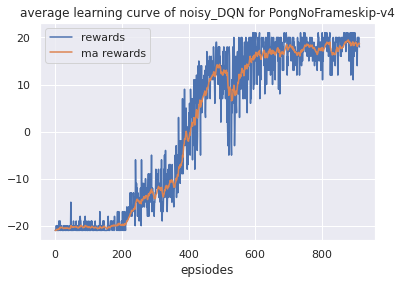

Start Evaluating!
20210629-194710
[20210629-194717: noisy_DQN] Episode:2: Frame:3404.0: Reward:20.0
[20210629-194718: noisy_DQN] Episode:3: Frame:5161.0: Reward:20.0
[20210629-194720: noisy_DQN] Episode:4: Frame:7395.0: Reward:21.0
[20210629-194726: noisy_DQN] Episode:5: Frame:9149.0: Reward:20.0
[20210629-194728: noisy_DQN] Episode:6: Frame:11380.0: Reward:21.0
[20210629-194728: noisy_DQN] Episode:7: Frame:13613.0: Reward:21.0
[20210629-194730: noisy_DQN] Episode:8: Frame:15844.0: Reward:21.0
[20210629-194734: noisy_DQN] Episode:9: Frame:17550.0: Reward:20.0
[20210629-194738: noisy_DQN] Episode:10: Frame:19739.0: Reward:21.0
[20210629-194738: noisy_DQN] Episode:11: Frame:21973.0: Reward:21.0
[20210629-194738: noisy_DQN] Episode:12: Frame:23679.0: Reward:20.0
[20210629-194742: noisy_DQN] Episode:13: Frame:25438.0: Reward:20.0
[20210629-194746: noisy_DQN] Episode:14: Frame:27195.0: Reward:20.0
[20210629-194748: noisy_DQN] Episode:15: Frame:29430.0: Reward:21.0
[20210629-194748: noisy_DQ

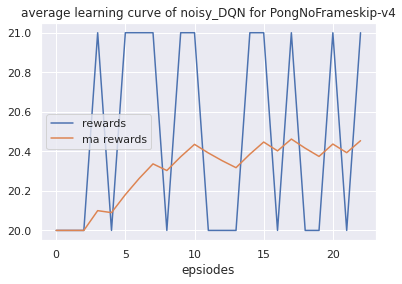

In [13]:
main()

# Prioritized_DQN

In [22]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'prioritized_DQN'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 8           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.train_eps = 700           # number of training episodes
        self.eval_eps = 50            # number of evaluation episodes
        self.max_train_frames = 1.5e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 300*2  # number of experience stored in memory before learning
        self.PER_alpha = 0.6                      # alpha for Prioritized Experience Replay, 0 - no importance sampling (IS); 1 - most IS 
        self.PER_beta = 0.4                       # beta for Prioritized Experience Replay, 0 - no annealing the bias from IS; 1 - Annealing the bias from IS 
        self.PER_beta_decay_method = None #'Linear'     # if None: no decay for PER beta
        self.PER_beta_decay = 1/self.memory_size/2  # decay rate for PER beta
        self.learn_freq = 2            # number of steps for one learning 
        self.sync_target_freq = 100     # number of learning steps for sync target model
        self.batch_size = 128*4          # number of examples in one batch
        self.lr = 0.0004                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.n_multi_step = 1          # number of steps of multi-step style gain 
        self.epsilon_start = 0.98      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.01        # ending epsilon
        self.epsilon_decay = 1/5000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'CNN'             # name of model
        self.hidden_dim = 512           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

In [23]:
def train(cfg,envs,agent):
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    envs.seed(cfg.seed)

    print('Start Training!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames'],history['loss']  = [],[],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_train_env),np.zeros(cfg.n_train_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0
#     memorys = [PrioritizedReplayBuffer(cfg.memory_size//cfg.n_train_env,cfg.PER_alpha) for _ in range(cfg.n_train_env)]
    memorys = [NaivePrioritizedBuffer(cfg.memory_size//cfg.n_train_env,cfg.PER_alpha) for _ in range(cfg.n_train_env)]
    if cfg.PER_beta_decay_method == 'Linear':
        PER_beta = lambda frame_idx: min(1.0, cfg.PER_beta + frame_idx * (1.0 - cfg.PER_beta)*cfg.PER_beta_decay)
    else:
        PER_beta = lambda frame_idx: min(1.0, cfg.PER_beta)

    states = envs.reset()
    while i_frame < cfg.max_train_frames:
        ### interactive with environments ###
        actions = agent.sample(states)
        if cfg.n_train_env == 1: actions = [actions]
    #     actions = np.random.randint(6,size=cfg.n_train_env)
        next_states,rewards,dones,infos = envs.step(actions)
        eps_rewards += rewards
        done_envs_ids = np.where(dones)[0]
        eps_frames += 1
        for memory,s,a,r,next_s,done in zip(memorys, states, actions, rewards, next_states, dones):
            memory.push(s,a,r,next_s,done)
        states = next_states
        i_frame += len(actions)
        ### updating agent ###
        if all([len(memory)>cfg.memory_warmup_size for memory in memorys]) and i_frame%cfg.learn_freq==0:
            batch_state,batch_action,batch_reward,batch_next_state,batch_done,batch_weight,batch_idx = [],[],[],[],[],[],[]
            sample_ids = np.random.choice(cfg.n_train_env,cfg.batch_size,p=[1/cfg.n_train_env]*cfg.n_train_env)
            sample_num = np.bincount(sample_ids, minlength=cfg.n_train_env)
            sample_num[sample_num==0] = 4
            for i,n in enumerate(sample_num):
                s,a,r,ns,d,w,idx = memorys[i].sample(n,PER_beta(agent.sample_steps))
                for batch, x in zip([batch_state,batch_action,batch_reward,batch_next_state,batch_done,batch_weight,batch_idx],
                                    [s,a,r,ns,d,w,idx]):
                    batch.append(x)
            batch_state,batch_action,batch_reward,batch_next_state,batch_done,batch_weight,batch_idx = map(
                lambda x:np.concatenate(x),[batch_state,batch_action,batch_reward,batch_next_state,batch_done,batch_weight,batch_idx])
            prios = agent.learn(batch_state,batch_action,batch_reward,batch_next_state,batch_done,batch_weight)
            prev_n = 0 
            for i,n in enumerate(sample_num):
                memorys[i].update_priorities(batch_idx[prev_n:prev_n+n],prios[prev_n:prev_n+n])
                prev_n += n
            history['loss'].append(prios.mean())
        ### recording historys ###
        if len(done_envs_ids) > 0:
            for r in eps_rewards[done_envs_ids]:
                history['rewards'].append(r)
                if history['ma_rewards']:
                    history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                else:
                    history['ma_rewards'].append(r)
            for n in eps_frames[done_envs_ids]:
                if history['frames']:
                    history['frames'].append(history['frames'][-1] + n)
                else:
                    history['frames'].append(n)
            eps_frames[done_envs_ids] = 0
            eps_rewards[done_envs_ids] = 0
            states[done_envs_ids] = envs.reset(done_envs_ids)
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 1000:
                prev_frame_verbose = history['frames'][-1]
                if history['loss']:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}: Loss:{history['loss'][-1]:.4f}")
                else:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
            if history['frames'][-1] - prev_frame_save >= cfg.max_train_frames//10:
                prev_frame_save = history['frames'][-1]
                make_dir(cfg.result_path,cfg.model_path+time)
                agent.save(path=cfg.model_path+time+'/')
    make_dir(cfg.result_path,cfg.model_path+time)
    agent.save(path=cfg.model_path+time+'/')
    return history

prioritized_DQN PongNoFrameskip-v4
Start Training!
20210628-093326
[20210628-093334: prioritized_DQN] Episode:1: Frame:811.0: Reward:-21.0: Loss:0.0414
[20210628-093335: prioritized_DQN] Episode:3: Frame:2463.0: Reward:-21.0: Loss:0.0362
[20210628-093338: prioritized_DQN] Episode:5: Frame:4271.0: Reward:-21.0: Loss:0.0412
[20210628-093339: prioritized_DQN] Episode:7: Frame:6268.0: Reward:-19.0: Loss:0.0397
[20210628-093341: prioritized_DQN] Episode:8: Frame:7319.0: Reward:-19.0: Loss:0.0434
[20210628-093354: prioritized_DQN] Episode:10: Frame:8955.0: Reward:-21.0: Loss:0.0124
[20210628-093359: prioritized_DQN] Episode:12: Frame:10536.0: Reward:-21.0: Loss:0.0097
[20210628-093401: prioritized_DQN] Episode:14: Frame:12461.0: Reward:-21.0: Loss:0.0072
[20210628-093403: prioritized_DQN] Episode:16: Frame:14489.0: Reward:-19.0: Loss:0.0074
[20210628-093415: prioritized_DQN] Episode:18: Frame:16129.0: Reward:-21.0: Loss:0.0078
[20210628-093421: prioritized_DQN] Episode:20: Frame:17700.0: Rew

[20210628-094232: prioritized_DQN] Episode:139: Frame:141658.0: Reward:-18.0: Loss:0.0244
[20210628-094233: prioritized_DQN] Episode:140: Frame:142864.0: Reward:-19.0: Loss:0.0334
[20210628-094243: prioritized_DQN] Episode:141: Frame:144086.0: Reward:-19.0: Loss:0.0272
[20210628-094247: prioritized_DQN] Episode:142: Frame:145258.0: Reward:-21.0: Loss:0.0250
[20210628-094255: prioritized_DQN] Episode:143: Frame:146556.0: Reward:-19.0: Loss:0.0256
[20210628-094302: prioritized_DQN] Episode:144: Frame:147619.0: Reward:-20.0: Loss:0.0193
[20210628-094304: prioritized_DQN] Episode:145: Frame:148729.0: Reward:-20.0: Loss:0.0164
[20210628-094314: prioritized_DQN] Episode:147: Frame:150867.0: Reward:-20.0: Loss:0.0234
[20210628-094317: prioritized_DQN] Episode:148: Frame:152171.0: Reward:-18.0: Loss:0.0188
[20210628-094327: prioritized_DQN] Episode:149: Frame:153375.0: Reward:-19.0: Loss:0.0240
[20210628-094336: prioritized_DQN] Episode:150: Frame:154746.0: Reward:-20.0: Loss:0.0250
[20210628-

[20210628-095352: prioritized_DQN] Episode:232: Frame:291274.0: Reward:-14.0: Loss:0.0211
[20210628-095405: prioritized_DQN] Episode:233: Frame:293517.0: Reward:-11.0: Loss:0.0095
[20210628-095410: prioritized_DQN] Episode:234: Frame:295621.0: Reward:-14.0: Loss:0.0106
[20210628-095411: prioritized_DQN] Episode:235: Frame:297566.0: Reward:-15.0: Loss:0.0084
[20210628-095431: prioritized_DQN] Episode:236: Frame:299435.0: Reward:-14.0: Loss:0.0089
[20210628-095431: prioritized_DQN] Episode:237: Frame:301954.0: Reward:-8.0: Loss:0.0238
[20210628-095439: prioritized_DQN] Episode:238: Frame:304059.0: Reward:-10.0: Loss:0.0053
[20210628-095443: prioritized_DQN] Episode:239: Frame:305711.0: Reward:-16.0: Loss:0.0063
[20210628-095509: prioritized_DQN] Episode:240: Frame:307451.0: Reward:-13.0: Loss:0.0061
[20210628-095516: prioritized_DQN] Episode:241: Frame:309250.0: Reward:-16.0: Loss:0.0078
[20210628-095531: prioritized_DQN] Episode:242: Frame:311983.0: Reward:-9.0: Loss:0.0057
[20210628-09

[20210628-100932: prioritized_DQN] Episode:324: Frame:504880.0: Reward:9.0: Loss:0.0093
[20210628-100933: prioritized_DQN] Episode:325: Frame:507092.0: Reward:-12.0: Loss:0.0078
[20210628-100952: prioritized_DQN] Episode:326: Frame:509452.0: Reward:-9.0: Loss:0.0112
[20210628-101002: prioritized_DQN] Episode:327: Frame:512092.0: Reward:-7.0: Loss:0.0076
[20210628-101021: prioritized_DQN] Episode:328: Frame:514740.0: Reward:-5.0: Loss:0.0126
[20210628-101030: prioritized_DQN] Episode:329: Frame:517424.0: Reward:-9.0: Loss:0.0103
[20210628-101036: prioritized_DQN] Episode:330: Frame:519940.0: Reward:-8.0: Loss:0.0079
[20210628-101047: prioritized_DQN] Episode:331: Frame:522797.0: Reward:-4.0: Loss:0.0074
[20210628-101055: prioritized_DQN] Episode:332: Frame:525212.0: Reward:-8.0: Loss:0.0089
[20210628-101115: prioritized_DQN] Episode:333: Frame:528284.0: Reward:3.0: Loss:0.0072
[20210628-101121: prioritized_DQN] Episode:334: Frame:530603.0: Reward:-9.0: Loss:0.0072
[20210628-101123: prio

[20210628-102614: prioritized_DQN] Episode:417: Frame:740837.0: Reward:16.0: Loss:0.0112
[20210628-102617: prioritized_DQN] Episode:418: Frame:743080.0: Reward:11.0: Loss:0.0067
[20210628-102627: prioritized_DQN] Episode:419: Frame:744993.0: Reward:17.0: Loss:0.0132
[20210628-102649: prioritized_DQN] Episode:420: Frame:746660.0: Reward:20.0: Loss:0.0087
[20210628-102655: prioritized_DQN] Episode:421: Frame:748813.0: Reward:12.0: Loss:0.0077
[20210628-102656: prioritized_DQN] Episode:422: Frame:751043.0: Reward:17.0: Loss:0.0077
[20210628-102659: prioritized_DQN] Episode:423: Frame:753059.0: Reward:18.0: Loss:0.0101
[20210628-102717: prioritized_DQN] Episode:424: Frame:755443.0: Reward:17.0: Loss:0.0127
[20210628-102722: prioritized_DQN] Episode:425: Frame:757186.0: Reward:19.0: Loss:0.0104
[20210628-102728: prioritized_DQN] Episode:426: Frame:759392.0: Reward:14.0: Loss:0.0060
[20210628-102732: prioritized_DQN] Episode:427: Frame:761829.0: Reward:11.0: Loss:0.0079
[20210628-102751: pri

[20210628-104032: prioritized_DQN] Episode:511: Frame:939967.0: Reward:14.0: Loss:0.0188
[20210628-104033: prioritized_DQN] Episode:512: Frame:942635.0: Reward:10.0: Loss:0.0068
[20210628-104043: prioritized_DQN] Episode:513: Frame:944892.0: Reward:13.0: Loss:0.0101
[20210628-104051: prioritized_DQN] Episode:514: Frame:947155.0: Reward:13.0: Loss:0.0119
[20210628-104102: prioritized_DQN] Episode:515: Frame:949398.0: Reward:11.0: Loss:0.0127
[20210628-104127: prioritized_DQN] Episode:516: Frame:951749.0: Reward:16.0: Loss:0.0127
[20210628-104131: prioritized_DQN] Episode:517: Frame:954305.0: Reward:6.0: Loss:0.0113
[20210628-104137: prioritized_DQN] Episode:518: Frame:956657.0: Reward:13.0: Loss:0.0161
[20210628-104146: prioritized_DQN] Episode:519: Frame:958843.0: Reward:13.0: Loss:0.0143
[20210628-104148: prioritized_DQN] Episode:520: Frame:960574.0: Reward:20.0: Loss:0.0111
[20210628-104158: prioritized_DQN] Episode:521: Frame:963124.0: Reward:9.0: Loss:0.0108
[20210628-104201: prior

[20210628-105449: prioritized_DQN] Episode:604: Frame:1141372.0: Reward:4.0: Loss:0.0076
[20210628-105452: prioritized_DQN] Episode:605: Frame:1143116.0: Reward:18.0: Loss:0.0091
[20210628-105525: prioritized_DQN] Episode:606: Frame:1145041.0: Reward:16.0: Loss:0.0074
[20210628-105528: prioritized_DQN] Episode:607: Frame:1146996.0: Reward:16.0: Loss:0.0095
[20210628-105534: prioritized_DQN] Episode:608: Frame:1148992.0: Reward:16.0: Loss:0.0086
[20210628-105547: prioritized_DQN] Episode:609: Frame:1150778.0: Reward:19.0: Loss:0.0095
[20210628-105552: prioritized_DQN] Episode:610: Frame:1153338.0: Reward:7.0: Loss:0.0124
[20210628-105603: prioritized_DQN] Episode:611: Frame:1155399.0: Reward:17.0: Loss:0.0080
[20210628-105604: prioritized_DQN] Episode:612: Frame:1157587.0: Reward:13.0: Loss:0.0121
[20210628-105610: prioritized_DQN] Episode:613: Frame:1159931.0: Reward:13.0: Loss:0.0068
[20210628-105633: prioritized_DQN] Episode:614: Frame:1161661.0: Reward:19.0: Loss:0.0120
[20210628-10

[20210628-110843: prioritized_DQN] Episode:696: Frame:1332008.0: Reward:15.0: Loss:0.0110
[20210628-110847: prioritized_DQN] Episode:697: Frame:1334004.0: Reward:15.0: Loss:0.0100
[20210628-110855: prioritized_DQN] Episode:698: Frame:1335938.0: Reward:18.0: Loss:0.0099
[20210628-110902: prioritized_DQN] Episode:699: Frame:1337759.0: Reward:18.0: Loss:0.0075
[20210628-110910: prioritized_DQN] Episode:700: Frame:1340045.0: Reward:9.0: Loss:0.0096
[20210628-110935: prioritized_DQN] Episode:701: Frame:1341709.0: Reward:20.0: Loss:0.0075
[20210628-110940: prioritized_DQN] Episode:702: Frame:1343536.0: Reward:18.0: Loss:0.0112
[20210628-110948: prioritized_DQN] Episode:703: Frame:1345734.0: Reward:12.0: Loss:0.0072
[20210628-110950: prioritized_DQN] Episode:704: Frame:1347542.0: Reward:18.0: Loss:0.0071
[20210628-110956: prioritized_DQN] Episode:705: Frame:1349430.0: Reward:15.0: Loss:0.0085
[20210628-111006: prioritized_DQN] Episode:706: Frame:1351375.0: Reward:18.0: Loss:0.0081
[20210628-1

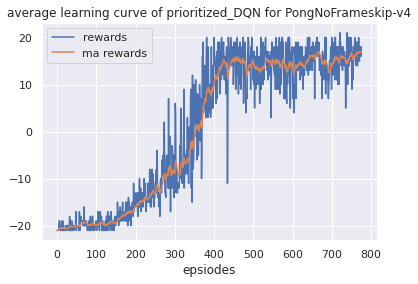

Start Evaluating!
20210628-112011
[20210628-112018: prioritized_DQN] Episode:3: Frame:4989.0: Reward:20.0
[20210628-112019: prioritized_DQN] Episode:4: Frame:6672.0: Reward:20.0
[20210628-112026: prioritized_DQN] Episode:5: Frame:8332.0: Reward:20.0
[20210628-112026: prioritized_DQN] Episode:6: Frame:10012.0: Reward:20.0
[20210628-112026: prioritized_DQN] Episode:7: Frame:11694.0: Reward:20.0
[20210628-112026: prioritized_DQN] Episode:8: Frame:13374.0: Reward:20.0
[20210628-112033: prioritized_DQN] Episode:9: Frame:15005.0: Reward:21.0
[20210628-112034: prioritized_DQN] Episode:10: Frame:16672.0: Reward:20.0
[20210628-112034: prioritized_DQN] Episode:11: Frame:18355.0: Reward:20.0
[20210628-112034: prioritized_DQN] Episode:12: Frame:20022.0: Reward:20.0
[20210628-112041: prioritized_DQN] Episode:13: Frame:21687.0: Reward:20.0
[20210628-112041: prioritized_DQN] Episode:14: Frame:23371.0: Reward:20.0
[20210628-112041: prioritized_DQN] Episode:15: Frame:25002.0: Reward:21.0
[20210628-1120

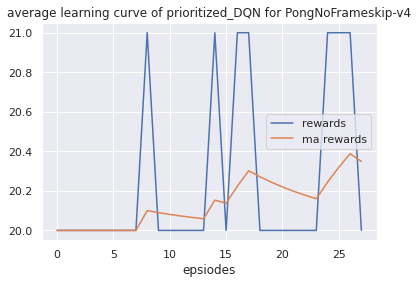

In [35]:
main()

# dueling_DQN

In [10]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'dueling_DQN'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 8           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.train_eps = 700           # number of training episodes
        self.eval_eps = 50            # number of evaluation episodes
        self.max_train_frames = 1.8e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 300*2  # number of experience stored in memory before learning
        self.learn_freq = 2            # number of steps for one learning 
        self.sync_target_freq = 16     # number of learning steps for sync target model
        self.batch_size = 128*4          # number of examples in one batch
        self.lr = 0.0002                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.n_multi_step = 1          # number of steps of multi-step style gain 
        self.epsilon_start = 0.98      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.01        # ending epsilon
        self.epsilon_decay = 1/5000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'DuelingCNN'             # name of model
        self.hidden_dim = 512           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

dueling_DQN PongNoFrameskip-v4
Start Training!
20210619-202532
[20210619-202539: dueling_DQN] Episode:1: Frame:819.0: Reward:-21.0: Loss:0.0225
[20210619-202541: dueling_DQN] Episode:3: Frame:2558.0: Reward:-20.0: Loss:0.0259
[20210619-202543: dueling_DQN] Episode:5: Frame:4454.0: Reward:-20.0: Loss:0.0126
[20210619-202543: dueling_DQN] Episode:6: Frame:5472.0: Reward:-18.0: Loss:0.0131
[20210619-202544: dueling_DQN] Episode:7: Frame:6503.0: Reward:-20.0: Loss:0.0127
[20210619-202544: dueling_DQN] Episode:8: Frame:7542.0: Reward:-20.0: Loss:0.0095
[20210619-202600: dueling_DQN] Episode:10: Frame:9241.0: Reward:-21.0: Loss:0.0180
[20210619-202602: dueling_DQN] Episode:12: Frame:11152.0: Reward:-21.0: Loss:0.0299
[20210619-202605: dueling_DQN] Episode:14: Frame:13046.0: Reward:-19.0: Loss:0.0161
[20210619-202606: dueling_DQN] Episode:15: Frame:14099.0: Reward:-19.0: Loss:0.0181
[20210619-202611: dueling_DQN] Episode:16: Frame:15439.0: Reward:-16.0: Loss:0.0150
[20210619-202621: dueling_D

[20210619-203240: dueling_DQN] Episode:114: Frame:151350.0: Reward:-20.0: Loss:0.0087
[20210619-203244: dueling_DQN] Episode:115: Frame:153303.0: Reward:-14.0: Loss:0.0118
[20210619-203246: dueling_DQN] Episode:116: Frame:155373.0: Reward:-14.0: Loss:0.0112
[20210619-203248: dueling_DQN] Episode:117: Frame:157229.0: Reward:-18.0: Loss:0.0109
[20210619-203251: dueling_DQN] Episode:118: Frame:158583.0: Reward:-20.0: Loss:0.0100
[20210619-203255: dueling_DQN] Episode:119: Frame:159953.0: Reward:-20.0: Loss:0.0122
[20210619-203258: dueling_DQN] Episode:120: Frame:161542.0: Reward:-19.0: Loss:0.0091
[20210619-203258: dueling_DQN] Episode:121: Frame:163698.0: Reward:-15.0: Loss:0.0108
[20210619-203315: dueling_DQN] Episode:122: Frame:164991.0: Reward:-19.0: Loss:0.0111
[20210619-203320: dueling_DQN] Episode:123: Frame:166710.0: Reward:-16.0: Loss:0.0128
[20210619-203331: dueling_DQN] Episode:124: Frame:168567.0: Reward:-17.0: Loss:0.0214
[20210619-203333: dueling_DQN] Episode:125: Frame:1707

[20210619-204318: dueling_DQN] Episode:210: Frame:367584.0: Reward:-13.0: Loss:0.0080
[20210619-204332: dueling_DQN] Episode:211: Frame:370477.0: Reward:-11.0: Loss:0.0078
[20210619-204351: dueling_DQN] Episode:212: Frame:373860.0: Reward:-2.0: Loss:0.0068
[20210619-204402: dueling_DQN] Episode:213: Frame:377119.0: Reward:-9.0: Loss:0.0114
[20210619-204402: dueling_DQN] Episode:214: Frame:380488.0: Reward:5.0: Loss:0.0069
[20210619-204410: dueling_DQN] Episode:215: Frame:383160.0: Reward:7.0: Loss:0.0057
[20210619-204426: dueling_DQN] Episode:216: Frame:386992.0: Reward:1.0: Loss:0.0068
[20210619-204430: dueling_DQN] Episode:217: Frame:390072.0: Reward:-5.0: Loss:0.0090
[20210619-204438: dueling_DQN] Episode:218: Frame:393616.0: Reward:3.0: Loss:0.0061
[20210619-204454: dueling_DQN] Episode:219: Frame:397127.0: Reward:-2.0: Loss:0.0103
[20210619-204506: dueling_DQN] Episode:220: Frame:400345.0: Reward:-5.0: Loss:0.0176
[20210619-204510: dueling_DQN] Episode:221: Frame:402892.0: Reward:

[20210619-205503: dueling_DQN] Episode:307: Frame:608878.0: Reward:18.0: Loss:0.0060
[20210619-205512: dueling_DQN] Episode:308: Frame:610723.0: Reward:18.0: Loss:0.0054
[20210619-205522: dueling_DQN] Episode:309: Frame:612564.0: Reward:18.0: Loss:0.0100
[20210619-205536: dueling_DQN] Episode:310: Frame:614608.0: Reward:16.0: Loss:0.0093
[20210619-205540: dueling_DQN] Episode:311: Frame:616365.0: Reward:19.0: Loss:0.0091
[20210619-205542: dueling_DQN] Episode:312: Frame:618256.0: Reward:17.0: Loss:0.0070
[20210619-205546: dueling_DQN] Episode:313: Frame:620554.0: Reward:16.0: Loss:0.0071
[20210619-205551: dueling_DQN] Episode:314: Frame:622613.0: Reward:20.0: Loss:0.0060
[20210619-205554: dueling_DQN] Episode:315: Frame:624413.0: Reward:20.0: Loss:0.0056
[20210619-205556: dueling_DQN] Episode:316: Frame:626926.0: Reward:14.0: Loss:0.0080
[20210619-205615: dueling_DQN] Episode:317: Frame:628589.0: Reward:20.0: Loss:0.0057
[20210619-205615: dueling_DQN] Episode:318: Frame:630860.0: Rewar

[20210619-210456: dueling_DQN] Episode:404: Frame:802681.0: Reward:16.0: Loss:0.0066
[20210619-210502: dueling_DQN] Episode:405: Frame:804576.0: Reward:19.0: Loss:0.0076
[20210619-210502: dueling_DQN] Episode:406: Frame:806308.0: Reward:18.0: Loss:0.0087
[20210619-210505: dueling_DQN] Episode:407: Frame:808036.0: Reward:20.0: Loss:0.0080
[20210619-210511: dueling_DQN] Episode:408: Frame:809887.0: Reward:19.0: Loss:0.0087
[20210619-210514: dueling_DQN] Episode:409: Frame:811718.0: Reward:19.0: Loss:0.0121
[20210619-210518: dueling_DQN] Episode:410: Frame:813495.0: Reward:19.0: Loss:0.0059
[20210619-210542: dueling_DQN] Episode:411: Frame:815720.0: Reward:16.0: Loss:0.0100
[20210619-210543: dueling_DQN] Episode:412: Frame:817365.0: Reward:21.0: Loss:0.0056
[20210619-210544: dueling_DQN] Episode:413: Frame:819326.0: Reward:18.0: Loss:0.0112
[20210619-210551: dueling_DQN] Episode:414: Frame:821312.0: Reward:16.0: Loss:0.0118
[20210619-210551: dueling_DQN] Episode:415: Frame:822976.0: Rewar

[20210619-211338: dueling_DQN] Episode:501: Frame:980196.0: Reward:20.0: Loss:0.0036
[20210619-211350: dueling_DQN] Episode:502: Frame:982492.0: Reward:16.0: Loss:0.0045
[20210619-211355: dueling_DQN] Episode:503: Frame:984127.0: Reward:21.0: Loss:0.0032
[20210619-211358: dueling_DQN] Episode:504: Frame:986303.0: Reward:18.0: Loss:0.0085
[20210619-211358: dueling_DQN] Episode:505: Frame:987999.0: Reward:20.0: Loss:0.0041
[20210619-211400: dueling_DQN] Episode:506: Frame:989876.0: Reward:19.0: Loss:0.0037
[20210619-211404: dueling_DQN] Episode:507: Frame:991668.0: Reward:19.0: Loss:0.0025
[20210619-211418: dueling_DQN] Episode:508: Frame:993381.0: Reward:20.0: Loss:0.0050
[20210619-211418: dueling_DQN] Episode:509: Frame:995044.0: Reward:20.0: Loss:0.0046
[20210619-211429: dueling_DQN] Episode:510: Frame:996676.0: Reward:21.0: Loss:0.0039
[20210619-211439: dueling_DQN] Episode:511: Frame:998458.0: Reward:19.0: Loss:0.0047
[20210619-211440: dueling_DQN] Episode:512: Frame:1000181.0: Rewa

[20210619-212234: dueling_DQN] Episode:597: Frame:1159560.0: Reward:20.0: Loss:0.0047
[20210619-212243: dueling_DQN] Episode:598: Frame:1161246.0: Reward:20.0: Loss:0.0042
[20210619-212246: dueling_DQN] Episode:599: Frame:1163381.0: Reward:16.0: Loss:0.0023
[20210619-212246: dueling_DQN] Episode:600: Frame:1165277.0: Reward:17.0: Loss:0.0026
[20210619-212259: dueling_DQN] Episode:601: Frame:1167400.0: Reward:15.0: Loss:0.0040
[20210619-212312: dueling_DQN] Episode:602: Frame:1169299.0: Reward:18.0: Loss:0.0057
[20210619-212314: dueling_DQN] Episode:603: Frame:1171201.0: Reward:18.0: Loss:0.0030
[20210619-212317: dueling_DQN] Episode:604: Frame:1173009.0: Reward:19.0: Loss:0.0017
[20210619-212318: dueling_DQN] Episode:605: Frame:1175210.0: Reward:15.0: Loss:0.0029
[20210619-212324: dueling_DQN] Episode:606: Frame:1176844.0: Reward:21.0: Loss:0.0028
[20210619-212328: dueling_DQN] Episode:607: Frame:1178772.0: Reward:20.0: Loss:0.0047
[20210619-212331: dueling_DQN] Episode:608: Frame:1180

[20210619-213203: dueling_DQN] Episode:693: Frame:1345744.0: Reward:17.0: Loss:0.0028
[20210619-213214: dueling_DQN] Episode:694: Frame:1347845.0: Reward:18.0: Loss:0.0042
[20210619-213221: dueling_DQN] Episode:695: Frame:1350505.0: Reward:9.0: Loss:0.0032
[20210619-213224: dueling_DQN] Episode:696: Frame:1352259.0: Reward:20.0: Loss:0.0041
[20210619-213227: dueling_DQN] Episode:697: Frame:1354829.0: Reward:10.0: Loss:0.0022
[20210619-213232: dueling_DQN] Episode:698: Frame:1356906.0: Reward:15.0: Loss:0.0063
[20210619-213233: dueling_DQN] Episode:699: Frame:1358874.0: Reward:18.0: Loss:0.0044
[20210619-213235: dueling_DQN] Episode:700: Frame:1361280.0: Reward:8.0: Loss:0.0022
[20210619-213254: dueling_DQN] Episode:701: Frame:1363008.0: Reward:20.0: Loss:0.0035
[20210619-213254: dueling_DQN] Episode:702: Frame:1365191.0: Reward:17.0: Loss:0.0038
[20210619-213303: dueling_DQN] Episode:703: Frame:1367007.0: Reward:18.0: Loss:0.0051
[20210619-213307: dueling_DQN] Episode:704: Frame:136883

[20210619-214113: dueling_DQN] Episode:789: Frame:1528081.0: Reward:21.0: Loss:0.0010
[20210619-214113: dueling_DQN] Episode:790: Frame:1530136.0: Reward:18.0: Loss:0.0016
[20210619-214118: dueling_DQN] Episode:791: Frame:1531945.0: Reward:19.0: Loss:0.0035
[20210619-214121: dueling_DQN] Episode:792: Frame:1533724.0: Reward:19.0: Loss:0.0036
[20210619-214124: dueling_DQN] Episode:793: Frame:1535348.0: Reward:21.0: Loss:0.0017
[20210619-214129: dueling_DQN] Episode:794: Frame:1537648.0: Reward:15.0: Loss:0.0024
[20210619-214133: dueling_DQN] Episode:795: Frame:1539496.0: Reward:20.0: Loss:0.0021
[20210619-214148: dueling_DQN] Episode:796: Frame:1541359.0: Reward:19.0: Loss:0.0027
[20210619-214152: dueling_DQN] Episode:797: Frame:1543011.0: Reward:21.0: Loss:0.0019
[20210619-214158: dueling_DQN] Episode:798: Frame:1544918.0: Reward:20.0: Loss:0.0021
[20210619-214158: dueling_DQN] Episode:799: Frame:1546623.0: Reward:21.0: Loss:0.0017
[20210619-214203: dueling_DQN] Episode:800: Frame:1548

[20210619-215006: dueling_DQN] Episode:885: Frame:1703687.0: Reward:19.0: Loss:0.0022
[20210619-215007: dueling_DQN] Episode:886: Frame:1705821.0: Reward:17.0: Loss:0.0017
[20210619-215008: dueling_DQN] Episode:887: Frame:1707612.0: Reward:19.0: Loss:0.0010
[20210619-215018: dueling_DQN] Episode:888: Frame:1709668.0: Reward:17.0: Loss:0.0016
[20210619-215023: dueling_DQN] Episode:889: Frame:1711429.0: Reward:21.0: Loss:0.0037
[20210619-215025: dueling_DQN] Episode:890: Frame:1713207.0: Reward:20.0: Loss:0.0019
[20210619-215036: dueling_DQN] Episode:891: Frame:1715034.0: Reward:19.0: Loss:0.0012
[20210619-215041: dueling_DQN] Episode:892: Frame:1717049.0: Reward:19.0: Loss:0.0019
[20210619-215051: dueling_DQN] Episode:893: Frame:1718917.0: Reward:19.0: Loss:0.0015
[20210619-215055: dueling_DQN] Episode:894: Frame:1720879.0: Reward:19.0: Loss:0.0011
[20210619-215057: dueling_DQN] Episode:895: Frame:1722984.0: Reward:15.0: Loss:0.0023
[20210619-215102: dueling_DQN] Episode:896: Frame:1724

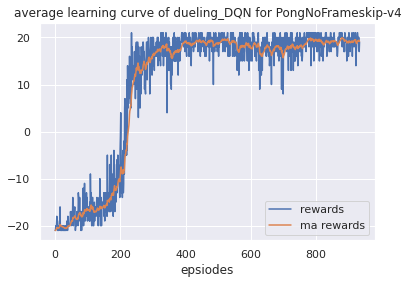

Start Evaluating!
20210619-215441
[20210619-215449: dueling_DQN] Episode:1: Frame:1622.0: Reward:21.0
[20210619-215449: dueling_DQN] Episode:3: Frame:4868.0: Reward:21.0
[20210619-215449: dueling_DQN] Episode:4: Frame:6502.0: Reward:21.0
[20210619-215457: dueling_DQN] Episode:5: Frame:8121.0: Reward:21.0
[20210619-215457: dueling_DQN] Episode:6: Frame:9752.0: Reward:21.0
[20210619-215457: dueling_DQN] Episode:7: Frame:11385.0: Reward:21.0
[20210619-215457: dueling_DQN] Episode:8: Frame:13016.0: Reward:21.0
[20210619-215506: dueling_DQN] Episode:9: Frame:14643.0: Reward:21.0
[20210619-215506: dueling_DQN] Episode:10: Frame:16277.0: Reward:21.0
[20210619-215506: dueling_DQN] Episode:11: Frame:17904.0: Reward:21.0
[20210619-215506: dueling_DQN] Episode:12: Frame:19582.0: Reward:20.0
[20210619-215514: dueling_DQN] Episode:13: Frame:21206.0: Reward:21.0
[20210619-215514: dueling_DQN] Episode:14: Frame:22828.0: Reward:21.0
[20210619-215515: dueling_DQN] Episode:15: Frame:24463.0: Reward:21.0

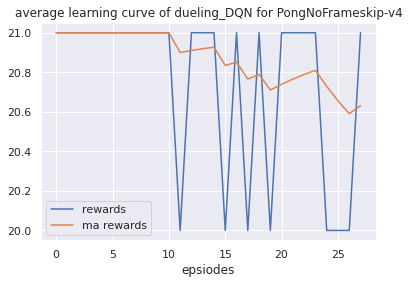

In [11]:
main()

# double_DQN 

In [9]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'double_DQN'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 8           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.train_eps = 700           # number of training episodes
        self.eval_eps = 50            # number of evaluation episodes
        self.max_train_frames = 1.8e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 300*2  # number of experience stored in memory before learning
        self.learn_freq = 2            # number of steps for one learning 
        self.sync_target_freq = 16     # number of learning steps for sync target model
        self.batch_size = 128*4          # number of examples in one batch
        self.lr = 0.0002                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.n_multi_step = 1          # number of steps of multi-step style gain 
        self.epsilon_start = 0.98      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.01        # ending epsilon
        self.epsilon_decay = 1/5000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'CNN'             # name of model
        self.hidden_dim = 512           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

double_DQN PongNoFrameskip-v4
Start Training!
20210619-223519
[20210619-223527: double_DQN] Episode:1: Frame:817.0: Reward:-21.0: Loss:0.0174
[20210619-223528: double_DQN] Episode:3: Frame:2487.0: Reward:-21.0: Loss:0.0308
[20210619-223531: double_DQN] Episode:5: Frame:4376.0: Reward:-19.0: Loss:0.0234
[20210619-223532: double_DQN] Episode:6: Frame:5399.0: Reward:-20.0: Loss:0.0173
[20210619-223532: double_DQN] Episode:7: Frame:6428.0: Reward:-21.0: Loss:0.0301
[20210619-223533: double_DQN] Episode:8: Frame:7500.0: Reward:-20.0: Loss:0.0186
[20210619-223551: double_DQN] Episode:10: Frame:9163.0: Reward:-21.0: Loss:0.0182
[20210619-223553: double_DQN] Episode:11: Frame:10200.0: Reward:-18.0: Loss:0.0184
[20210619-223553: double_DQN] Episode:12: Frame:11260.0: Reward:-21.0: Loss:0.0212
[20210619-223554: double_DQN] Episode:14: Frame:13083.0: Reward:-20.0: Loss:0.0282
[20210619-223556: double_DQN] Episode:16: Frame:15025.0: Reward:-20.0: Loss:0.0235
[20210619-223611: double_DQN] Episode:1

[20210619-224315: double_DQN] Episode:145: Frame:149126.0: Reward:-20.0: Loss:0.0169
[20210619-224317: double_DQN] Episode:146: Frame:151209.0: Reward:-13.0: Loss:0.0095
[20210619-224337: double_DQN] Episode:147: Frame:152644.0: Reward:-19.0: Loss:0.0128
[20210619-224340: double_DQN] Episode:148: Frame:154410.0: Reward:-15.0: Loss:0.0114
[20210619-224341: double_DQN] Episode:149: Frame:155870.0: Reward:-15.0: Loss:0.0082
[20210619-224342: double_DQN] Episode:150: Frame:157339.0: Reward:-18.0: Loss:0.0134
[20210619-224344: double_DQN] Episode:151: Frame:158938.0: Reward:-17.0: Loss:0.0093
[20210619-224354: double_DQN] Episode:152: Frame:160285.0: Reward:-19.0: Loss:0.0087
[20210619-224354: double_DQN] Episode:153: Frame:161815.0: Reward:-18.0: Loss:0.0093
[20210619-224359: double_DQN] Episode:154: Frame:163312.0: Reward:-18.0: Loss:0.0102
[20210619-224414: double_DQN] Episode:155: Frame:164526.0: Reward:-20.0: Loss:0.0111
[20210619-224419: double_DQN] Episode:156: Frame:166071.0: Reward

[20210619-225426: double_DQN] Episode:242: Frame:340821.0: Reward:-15.0: Loss:0.0131
[20210619-225432: double_DQN] Episode:243: Frame:342848.0: Reward:-15.0: Loss:0.0120
[20210619-225440: double_DQN] Episode:244: Frame:345473.0: Reward:-15.0: Loss:0.0094
[20210619-225443: double_DQN] Episode:245: Frame:347601.0: Reward:-16.0: Loss:0.0111
[20210619-225446: double_DQN] Episode:246: Frame:350106.0: Reward:-12.0: Loss:0.0139
[20210619-225459: double_DQN] Episode:247: Frame:352703.0: Reward:-8.0: Loss:0.0133
[20210619-225510: double_DQN] Episode:248: Frame:355529.0: Reward:-9.0: Loss:0.0077
[20210619-225511: double_DQN] Episode:249: Frame:357365.0: Reward:-15.0: Loss:0.0069
[20210619-225536: double_DQN] Episode:250: Frame:359987.0: Reward:-13.0: Loss:0.0075
[20210619-225537: double_DQN] Episode:251: Frame:362150.0: Reward:-16.0: Loss:0.0081
[20210619-225544: double_DQN] Episode:252: Frame:364842.0: Reward:-12.0: Loss:0.0070
[20210619-225611: double_DQN] Episode:253: Frame:368076.0: Reward:-

[20210619-231015: double_DQN] Episode:340: Frame:624985.0: Reward:14.0: Loss:0.0101
[20210619-231026: double_DQN] Episode:341: Frame:628259.0: Reward:2.0: Loss:0.0106
[20210619-231044: double_DQN] Episode:342: Frame:631325.0: Reward:6.0: Loss:0.0133
[20210619-231046: double_DQN] Episode:343: Frame:633509.0: Reward:16.0: Loss:0.0055
[20210619-231107: double_DQN] Episode:344: Frame:636055.0: Reward:10.0: Loss:0.0125
[20210619-231112: double_DQN] Episode:345: Frame:638442.0: Reward:13.0: Loss:0.0074
[20210619-231113: double_DQN] Episode:346: Frame:641875.0: Reward:-2.0: Loss:0.0052
[20210619-231115: double_DQN] Episode:347: Frame:644121.0: Reward:14.0: Loss:0.0114
[20210619-231123: double_DQN] Episode:348: Frame:646574.0: Reward:10.0: Loss:0.0090
[20210619-231147: double_DQN] Episode:349: Frame:649514.0: Reward:9.0: Loss:0.0073
[20210619-231158: double_DQN] Episode:350: Frame:652121.0: Reward:11.0: Loss:0.0077
[20210619-231207: double_DQN] Episode:351: Frame:655134.0: Reward:9.0: Loss:0.0

[20210619-232353: double_DQN] Episode:438: Frame:865433.0: Reward:16.0: Loss:0.0055
[20210619-232403: double_DQN] Episode:439: Frame:868320.0: Reward:7.0: Loss:0.0069
[20210619-232406: double_DQN] Episode:440: Frame:870225.0: Reward:18.0: Loss:0.0054
[20210619-232422: double_DQN] Episode:441: Frame:872278.0: Reward:15.0: Loss:0.0066
[20210619-232442: double_DQN] Episode:442: Frame:874138.0: Reward:19.0: Loss:0.0057
[20210619-232444: double_DQN] Episode:443: Frame:876137.0: Reward:16.0: Loss:0.0044
[20210619-232445: double_DQN] Episode:444: Frame:878090.0: Reward:18.0: Loss:0.0067
[20210619-232445: double_DQN] Episode:445: Frame:879942.0: Reward:19.0: Loss:0.0052
[20210619-232454: double_DQN] Episode:446: Frame:882355.0: Reward:13.0: Loss:0.0094
[20210619-232507: double_DQN] Episode:447: Frame:884611.0: Reward:15.0: Loss:0.0062
[20210619-232514: double_DQN] Episode:448: Frame:887025.0: Reward:13.0: Loss:0.0049
[20210619-232519: double_DQN] Episode:449: Frame:889064.0: Reward:17.0: Loss:

[20210619-233548: double_DQN] Episode:536: Frame:1066690.0: Reward:18.0: Loss:0.0042
[20210619-233552: double_DQN] Episode:537: Frame:1068678.0: Reward:17.0: Loss:0.0035
[20210619-233605: double_DQN] Episode:538: Frame:1070573.0: Reward:20.0: Loss:0.0039
[20210619-233618: double_DQN] Episode:539: Frame:1072593.0: Reward:18.0: Loss:0.0036
[20210619-233618: double_DQN] Episode:540: Frame:1074992.0: Reward:14.0: Loss:0.0042
[20210619-233623: double_DQN] Episode:541: Frame:1076627.0: Reward:21.0: Loss:0.0050
[20210619-233628: double_DQN] Episode:542: Frame:1078421.0: Reward:19.0: Loss:0.0072
[20210619-233635: double_DQN] Episode:543: Frame:1080323.0: Reward:18.0: Loss:0.0029
[20210619-233649: double_DQN] Episode:544: Frame:1082368.0: Reward:17.0: Loss:0.0037
[20210619-233652: double_DQN] Episode:545: Frame:1084636.0: Reward:16.0: Loss:0.0055
[20210619-233701: double_DQN] Episode:546: Frame:1086641.0: Reward:19.0: Loss:0.0041
[20210619-233707: double_DQN] Episode:547: Frame:1088423.0: Rewar

[20210619-234640: double_DQN] Episode:633: Frame:1254896.0: Reward:19.0: Loss:0.0032
[20210619-234647: double_DQN] Episode:634: Frame:1256650.0: Reward:20.0: Loss:0.0021
[20210619-234649: double_DQN] Episode:635: Frame:1258536.0: Reward:17.0: Loss:0.0044
[20210619-234657: double_DQN] Episode:636: Frame:1260176.0: Reward:21.0: Loss:0.0049
[20210619-234704: double_DQN] Episode:637: Frame:1262197.0: Reward:18.0: Loss:0.0041
[20210619-234710: double_DQN] Episode:638: Frame:1264200.0: Reward:17.0: Loss:0.0045
[20210619-234713: double_DQN] Episode:639: Frame:1265822.0: Reward:21.0: Loss:0.0028
[20210619-234725: double_DQN] Episode:640: Frame:1267738.0: Reward:19.0: Loss:0.0058
[20210619-234729: double_DQN] Episode:641: Frame:1269544.0: Reward:19.0: Loss:0.0032
[20210619-234739: double_DQN] Episode:642: Frame:1271469.0: Reward:19.0: Loss:0.0024
[20210619-234745: double_DQN] Episode:643: Frame:1273269.0: Reward:20.0: Loss:0.0026
[20210619-234747: double_DQN] Episode:644: Frame:1275416.0: Rewar

[20210619-235729: double_DQN] Episode:730: Frame:1442447.0: Reward:20.0: Loss:0.0059
[20210619-235740: double_DQN] Episode:731: Frame:1444455.0: Reward:17.0: Loss:0.0022
[20210619-235743: double_DQN] Episode:732: Frame:1446112.0: Reward:21.0: Loss:0.0066
[20210619-235746: double_DQN] Episode:733: Frame:1447927.0: Reward:19.0: Loss:0.0034
[20210619-235750: double_DQN] Episode:734: Frame:1449682.0: Reward:20.0: Loss:0.0051
[20210619-235753: double_DQN] Episode:735: Frame:1451886.0: Reward:16.0: Loss:0.0031
[20210619-235821: double_DQN] Episode:736: Frame:1453811.0: Reward:19.0: Loss:0.0024
[20210619-235824: double_DQN] Episode:737: Frame:1455916.0: Reward:16.0: Loss:0.0063
[20210619-235825: double_DQN] Episode:738: Frame:1457548.0: Reward:21.0: Loss:0.0047
[20210619-235827: double_DQN] Episode:739: Frame:1459625.0: Reward:15.0: Loss:0.0025
[20210619-235831: double_DQN] Episode:740: Frame:1461376.0: Reward:18.0: Loss:0.0023
[20210619-235838: double_DQN] Episode:741: Frame:1463276.0: Rewar

[20210620-000824: double_DQN] Episode:827: Frame:1629033.0: Reward:13.0: Loss:0.0024
[20210620-000824: double_DQN] Episode:828: Frame:1630720.0: Reward:20.0: Loss:0.0032
[20210620-000847: double_DQN] Episode:829: Frame:1632814.0: Reward:17.0: Loss:0.0022
[20210620-000848: double_DQN] Episode:830: Frame:1634867.0: Reward:17.0: Loss:0.0015
[20210620-000854: double_DQN] Episode:831: Frame:1636804.0: Reward:17.0: Loss:0.0031
[20210620-000900: double_DQN] Episode:832: Frame:1638459.0: Reward:20.0: Loss:0.0018
[20210620-000911: double_DQN] Episode:833: Frame:1641147.0: Reward:10.0: Loss:0.0017
[20210620-000917: double_DQN] Episode:834: Frame:1643310.0: Reward:12.0: Loss:0.0017
[20210620-000921: double_DQN] Episode:835: Frame:1645375.0: Reward:15.0: Loss:0.0022
[20210620-000922: double_DQN] Episode:836: Frame:1647490.0: Reward:14.0: Loss:0.0029
[20210620-000940: double_DQN] Episode:837: Frame:1649393.0: Reward:19.0: Loss:0.0017
[20210620-000946: double_DQN] Episode:838: Frame:1651261.0: Rewar

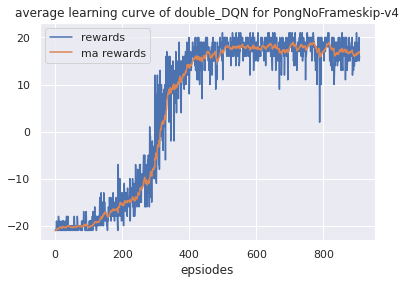

Start Evaluating!
20210620-001750
[20210620-001757: double_DQN] Episode:1: Frame:1596.0: Reward:21.0
[20210620-001757: double_DQN] Episode:3: Frame:4842.0: Reward:20.0
[20210620-001757: double_DQN] Episode:4: Frame:6531.0: Reward:20.0
[20210620-001805: double_DQN] Episode:5: Frame:8124.0: Reward:21.0
[20210620-001805: double_DQN] Episode:6: Frame:9810.0: Reward:20.0
[20210620-001805: double_DQN] Episode:7: Frame:11498.0: Reward:20.0
[20210620-001806: double_DQN] Episode:8: Frame:13184.0: Reward:20.0
[20210620-001813: double_DQN] Episode:9: Frame:14811.0: Reward:20.0
[20210620-001813: double_DQN] Episode:10: Frame:16423.0: Reward:20.0
[20210620-001814: double_DQN] Episode:11: Frame:18112.0: Reward:20.0
[20210620-001814: double_DQN] Episode:12: Frame:19739.0: Reward:20.0
[20210620-001820: double_DQN] Episode:13: Frame:21337.0: Reward:21.0
[20210620-001821: double_DQN] Episode:14: Frame:22933.0: Reward:21.0
[20210620-001822: double_DQN] Episode:15: Frame:24623.0: Reward:20.0
[20210620-001

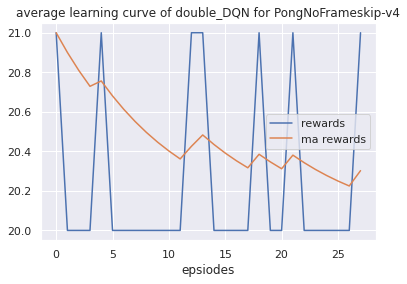

In [10]:
main()

# DQN

In [ ]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'DQN'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 8           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.train_eps = 700           # number of training episodes
        self.eval_eps = 50            # number of evaluation episodes
        self.max_train_frames = 1.8e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 300*2  # number of experience stored in memory before learning
        self.learn_freq = 2            # number of steps for one learning 
        self.sync_target_freq = 16     # number of learning steps for sync target model
        self.batch_size = 128*4          # number of examples in one batch
        self.lr = 0.0001                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.n_multi_step = 1          # number of steps of multi-step style gain 
        self.epsilon_start = 0.98      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.01        # ending epsilon
        self.epsilon_decay = 1/5000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'CNN'             # name of model
        self.hidden_dim = 512           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

DQN PongNoFrameskip-v4
Start Training!
20210618-175603
[20210618-175610: DQN] Episode:1: Frame:811.0: Reward:-21.0: Loss:0.0196
[20210618-175611: DQN] Episode:3: Frame:2473.0: Reward:-21.0: Loss:0.0273
[20210618-175613: DQN] Episode:5: Frame:4318.0: Reward:-21.0: Loss:0.0248
[20210618-175614: DQN] Episode:6: Frame:5324.0: Reward:-19.0: Loss:0.0268
[20210618-175615: DQN] Episode:7: Frame:6340.0: Reward:-20.0: Loss:0.0865
[20210618-175615: DQN] Episode:8: Frame:7359.0: Reward:-19.0: Loss:0.0413
[20210618-175627: DQN] Episode:10: Frame:8965.0: Reward:-21.0: Loss:0.0441
[20210618-175630: DQN] Episode:12: Frame:10631.0: Reward:-21.0: Loss:0.0454
[20210618-175630: DQN] Episode:14: Frame:12253.0: Reward:-21.0: Loss:0.0272
[20210618-175633: DQN] Episode:16: Frame:13959.0: Reward:-21.0: Loss:0.0873
[20210618-175647: DQN] Episode:18: Frame:15775.0: Reward:-21.0: Loss:0.0227
[20210618-175650: DQN] Episode:20: Frame:17506.0: Reward:-21.0: Loss:0.0570
[20210618-175652: DQN] Episode:22: Frame:19724.

[20210618-180302: DQN] Episode:137: Frame:159061.0: Reward:-16.0: Loss:0.0174
[20210618-180306: DQN] Episode:138: Frame:160530.0: Reward:-19.0: Loss:0.0148
[20210618-180314: DQN] Episode:139: Frame:162232.0: Reward:-19.0: Loss:0.0142
[20210618-180325: DQN] Episode:140: Frame:164055.0: Reward:-14.0: Loss:0.0123
[20210618-180328: DQN] Episode:141: Frame:165607.0: Reward:-19.0: Loss:0.0142
[20210618-180329: DQN] Episode:142: Frame:167435.0: Reward:-15.0: Loss:0.0238
[20210618-180330: DQN] Episode:143: Frame:168941.0: Reward:-17.0: Loss:0.0126
[20210618-180331: DQN] Episode:144: Frame:170863.0: Reward:-17.0: Loss:0.0200
[20210618-180339: DQN] Episode:145: Frame:172340.0: Reward:-16.0: Loss:0.0165
[20210618-180346: DQN] Episode:146: Frame:174336.0: Reward:-17.0: Loss:0.0112
[20210618-180350: DQN] Episode:147: Frame:175922.0: Reward:-19.0: Loss:0.0170
[20210618-180401: DQN] Episode:148: Frame:177310.0: Reward:-20.0: Loss:0.0135
[20210618-180407: DQN] Episode:149: Frame:179090.0: Reward:-14.0

[20210618-181254: DQN] Episode:243: Frame:374537.0: Reward:-14.0: Loss:0.0100
[20210618-181304: DQN] Episode:244: Frame:377124.0: Reward:-16.0: Loss:0.0140
[20210618-181310: DQN] Episode:245: Frame:380142.0: Reward:-16.0: Loss:0.0112
[20210618-181320: DQN] Episode:246: Frame:382964.0: Reward:-8.0: Loss:0.0130
[20210618-181328: DQN] Episode:247: Frame:385052.0: Reward:-15.0: Loss:0.0170
[20210618-181331: DQN] Episode:248: Frame:388452.0: Reward:-8.0: Loss:0.0072
[20210618-181338: DQN] Episode:249: Frame:390617.0: Reward:-15.0: Loss:0.0081
[20210618-181350: DQN] Episode:250: Frame:393864.0: Reward:-6.0: Loss:0.0185
[20210618-181357: DQN] Episode:251: Frame:396756.0: Reward:-9.0: Loss:0.0110
[20210618-181359: DQN] Episode:252: Frame:398948.0: Reward:-15.0: Loss:0.0105
[20210618-181359: DQN] Episode:253: Frame:401466.0: Reward:-14.0: Loss:0.0111
[20210618-181413: DQN] Episode:254: Frame:403469.0: Reward:-15.0: Loss:0.0104
[20210618-181418: DQN] Episode:255: Frame:405574.0: Reward:-14.0: Lo

[20210618-182820: DQN] Episode:350: Frame:696309.0: Reward:-8.0: Loss:0.0078
[20210618-182823: DQN] Episode:351: Frame:699191.0: Reward:9.0: Loss:0.0068
[20210618-182829: DQN] Episode:352: Frame:701375.0: Reward:17.0: Loss:0.0194
[20210618-182843: DQN] Episode:353: Frame:704513.0: Reward:6.0: Loss:0.0116
[20210618-182854: DQN] Episode:354: Frame:707923.0: Reward:6.0: Loss:0.0093
[20210618-182856: DQN] Episode:355: Frame:711205.0: Reward:6.0: Loss:0.0077
[20210618-182858: DQN] Episode:356: Frame:714955.0: Reward:4.0: Loss:0.0080
[20210618-182912: DQN] Episode:357: Frame:718508.0: Reward:-4.0: Loss:0.0074
[20210618-182916: DQN] Episode:358: Frame:720989.0: Reward:13.0: Loss:0.0093
[20210618-182924: DQN] Episode:359: Frame:723718.0: Reward:15.0: Loss:0.0078
[20210618-182936: DQN] Episode:360: Frame:726615.0: Reward:9.0: Loss:0.0088
[20210618-182955: DQN] Episode:361: Frame:729232.0: Reward:12.0: Loss:0.0096
[20210618-183004: DQN] Episode:362: Frame:732126.0: Reward:9.0: Loss:0.0086
[20210

[20210618-184221: DQN] Episode:458: Frame:990819.0: Reward:14.0: Loss:0.0063
[20210618-184236: DQN] Episode:459: Frame:992869.0: Reward:16.0: Loss:0.0098
[20210618-184244: DQN] Episode:460: Frame:994747.0: Reward:20.0: Loss:0.0086
[20210618-184245: DQN] Episode:461: Frame:997176.0: Reward:13.0: Loss:0.0071
[20210618-184246: DQN] Episode:462: Frame:999296.0: Reward:16.0: Loss:0.0063
[20210618-184250: DQN] Episode:463: Frame:1001574.0: Reward:17.0: Loss:0.0117
[20210618-184255: DQN] Episode:464: Frame:1004329.0: Reward:13.0: Loss:0.0108
[20210618-184258: DQN] Episode:465: Frame:1006161.0: Reward:19.0: Loss:0.0086
[20210618-184325: DQN] Episode:466: Frame:1007949.0: Reward:19.0: Loss:0.0037
[20210618-184326: DQN] Episode:467: Frame:1010860.0: Reward:10.0: Loss:0.0059
[20210618-184327: DQN] Episode:468: Frame:1013168.0: Reward:17.0: Loss:0.0103
[20210618-184332: DQN] Episode:469: Frame:1015269.0: Reward:17.0: Loss:0.0063
[20210618-184333: DQN] Episode:470: Frame:1017450.0: Reward:15.0: Los

[20210618-185341: DQN] Episode:564: Frame:1225215.0: Reward:18.0: Loss:0.0049
[20210618-185348: DQN] Episode:565: Frame:1227289.0: Reward:15.0: Loss:0.0039
[20210618-185349: DQN] Episode:566: Frame:1229690.0: Reward:16.0: Loss:0.0034
[20210618-185353: DQN] Episode:567: Frame:1232238.0: Reward:12.0: Loss:0.0093
[20210618-185359: DQN] Episode:568: Frame:1234769.0: Reward:16.0: Loss:0.0059
[20210618-185406: DQN] Episode:569: Frame:1236643.0: Reward:18.0: Loss:0.0043
[20210618-185417: DQN] Episode:570: Frame:1238577.0: Reward:19.0: Loss:0.0044
[20210618-185430: DQN] Episode:571: Frame:1240761.0: Reward:18.0: Loss:0.0047
[20210618-185433: DQN] Episode:572: Frame:1242507.0: Reward:20.0: Loss:0.0039
[20210618-185434: DQN] Episode:573: Frame:1245050.0: Reward:14.0: Loss:0.0030
[20210618-185434: DQN] Episode:574: Frame:1247142.0: Reward:15.0: Loss:0.0039
[20210618-185435: DQN] Episode:575: Frame:1249182.0: Reward:16.0: Loss:0.0039
[20210618-185446: DQN] Episode:576: Frame:1250964.0: Reward:19.0

[20210618-190344: DQN] Episode:670: Frame:1442173.0: Reward:20.0: Loss:0.0061
[20210618-190350: DQN] Episode:671: Frame:1444689.0: Reward:13.0: Loss:0.0071
[20210618-190351: DQN] Episode:672: Frame:1446754.0: Reward:16.0: Loss:0.0072
[20210618-190359: DQN] Episode:673: Frame:1448693.0: Reward:18.0: Loss:0.0040
[20210618-190403: DQN] Episode:674: Frame:1450711.0: Reward:18.0: Loss:0.0044
[20210618-190408: DQN] Episode:675: Frame:1452357.0: Reward:21.0: Loss:0.0038
[20210618-190412: DQN] Episode:676: Frame:1454895.0: Reward:14.0: Loss:0.0033
[20210618-190426: DQN] Episode:677: Frame:1456543.0: Reward:21.0: Loss:0.0144
[20210618-190427: DQN] Episode:678: Frame:1458537.0: Reward:16.0: Loss:0.0045
[20210618-190435: DQN] Episode:679: Frame:1461239.0: Reward:12.0: Loss:0.0043
[20210618-190439: DQN] Episode:680: Frame:1463050.0: Reward:18.0: Loss:0.0039
[20210618-190440: DQN] Episode:681: Frame:1465290.0: Reward:17.0: Loss:0.0071
[20210618-190446: DQN] Episode:682: Frame:1467262.0: Reward:19.0

[20210618-191329: DQN] Episode:776: Frame:1653390.0: Reward:19.0: Loss:0.0061
[20210618-191337: DQN] Episode:777: Frame:1655262.0: Reward:18.0: Loss:0.0034
[20210618-191341: DQN] Episode:778: Frame:1657475.0: Reward:16.0: Loss:0.0029
[20210618-191343: DQN] Episode:779: Frame:1659337.0: Reward:19.0: Loss:0.0043
[20210618-191348: DQN] Episode:780: Frame:1662108.0: Reward:12.0: Loss:0.0046
[20210618-191351: DQN] Episode:781: Frame:1664026.0: Reward:19.0: Loss:0.0022
[20210618-191406: DQN] Episode:782: Frame:1665690.0: Reward:20.0: Loss:0.0018
[20210618-191414: DQN] Episode:783: Frame:1667719.0: Reward:17.0: Loss:0.0029
[20210618-191415: DQN] Episode:784: Frame:1669586.0: Reward:18.0: Loss:0.0025
[20210618-191424: DQN] Episode:785: Frame:1671475.0: Reward:19.0: Loss:0.0034
[20210618-191429: DQN] Episode:786: Frame:1673321.0: Reward:19.0: Loss:0.0021
[20210618-191431: DQN] Episode:787: Frame:1675101.0: Reward:20.0: Loss:0.0026
[20210618-191440: DQN] Episode:788: Frame:1677131.0: Reward:18.0

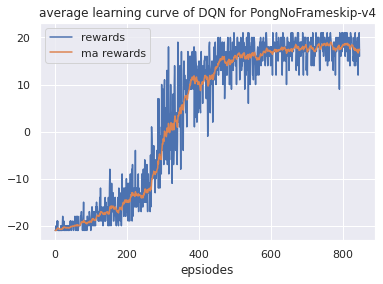

Start Evaluating!
20210618-192004
[20210618-192012: DQN] Episode:1: Frame:1727.0: Reward:20.0
[20210618-192013: DQN] Episode:2: Frame:3477.0: Reward:19.0
[20210618-192013: DQN] Episode:4: Frame:7147.0: Reward:19.0
[20210618-192020: DQN] Episode:5: Frame:8871.0: Reward:20.0
[20210618-192021: DQN] Episode:6: Frame:10655.0: Reward:20.0
[20210618-192021: DQN] Episode:7: Frame:12439.0: Reward:20.0
[20210618-192021: DQN] Episode:8: Frame:14225.0: Reward:20.0
[20210618-192029: DQN] Episode:9: Frame:16064.0: Reward:19.0
[20210618-192029: DQN] Episode:10: Frame:17814.0: Reward:19.0
[20210618-192029: DQN] Episode:11: Frame:19653.0: Reward:19.0
[20210618-192029: DQN] Episode:12: Frame:21408.0: Reward:20.0
[20210618-192037: DQN] Episode:13: Frame:23137.0: Reward:20.0
[20210618-192037: DQN] Episode:14: Frame:24864.0: Reward:20.0
[20210618-192038: DQN] Episode:15: Frame:26619.0: Reward:20.0
[20210618-192038: DQN] Episode:16: Frame:28407.0: Reward:20.0
[20210618-192045: DQN] Episode:17: Frame:30037.0

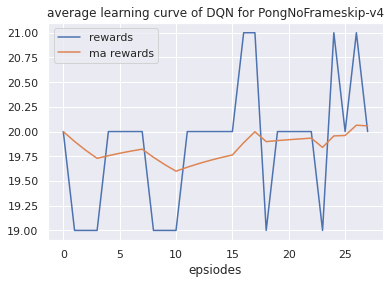

In [16]:
main()

results saved!


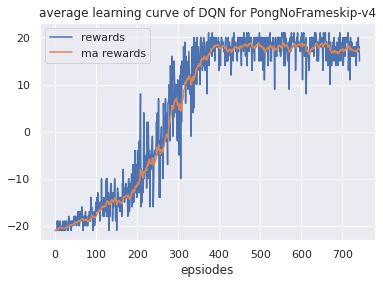

In [55]:
make_dir(cfg.result_path,cfg.model_path)
agent.save(path=cfg.model_path)
save_results(history,tag='train',path=cfg.result_path)
plot_rewards(history['rewards'],history['ma_rewards'],tag="train",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

In [11]:
cfg = config()
agent = Agent((1,84,84),6,cfg)

In [12]:
import numpy as np
batch_state = np.random.randn(12,1,84,84)
batch_state = torch.as_tensor(batch_state, device=cfg.device, dtype=torch.float32)
batch_action = [0,0,0,0,1,1,1,1,2,2,2,2]
batch_action = torch.as_tensor(batch_action,device=cfg.device).unsqueeze(1)

In [15]:
agent.policy_net(batch_state).max(1)[1]#.unsqueeze(1)

tensor([0.0575, 0.0606, 0.0410, 0.0494, 0.0537, 0.0344, 0.0379, 0.0673, 0.0545,
        0.0616, 0.0417, 0.0437], device='cuda:0', grad_fn=<MaxBackward0>)

In [22]:
agent.policy_net(batch_state).gather(1,batch_action)

tensor([[-0.0438],
        [-0.0373],
        [-0.0459],
        [-0.0407],
        [-0.0264],
        [-0.0207],
        [-0.0086],
        [-0.0276],
        [-0.0412],
        [-0.0276],
        [-0.0379],
        [-0.0366]], device='cuda:0', grad_fn=<GatherBackward>)

In [24]:
batch_action*(1-batch_action)

tensor([[ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [-2],
        [-2],
        [-2],
        [-2]], device='cuda:0')

In [15]:
prob_alpha = 1
prios = np.array([0.1,0.2,0.3,0.4,0.5])
probs  = prios ** prob_alpha
probs /= probs.sum()
np.random.choice(5, 2, p=probs)

array([4, 4])